<a href="https://colab.research.google.com/github/lgiesen/forest-height/blob/main/1_data_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
# Load data code is in separate notebook
%run "/content/drive/MyDrive/Colab Notebooks/0_load_data.ipynb"

Mounted at /content/drive
0_load_data.ipynb completed.


# Data Augmentation

### Creating Cutouts
Split the large image into smaller sub-images. Use these for training and prediction.

Option 1: Simple Loop

In [ ]:
batchsize = 16
i = 0

X_batch = X_train[i: i+batchsize]
print('X_batch.shape: ', X_batch.shape)  # it should be (16, 3, 60, 80)

In [ ]:
for i in range(0, len(X_train), batchsize):
    X_batch = X_train[i: i+batchsize]

Option 2: Use a library

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
tile shape: (256, 256) s_src: (slice(0, 192, None), slice(0, 192, None)) s_dst: (slice(0, 192, None), slice(0, 192, None))


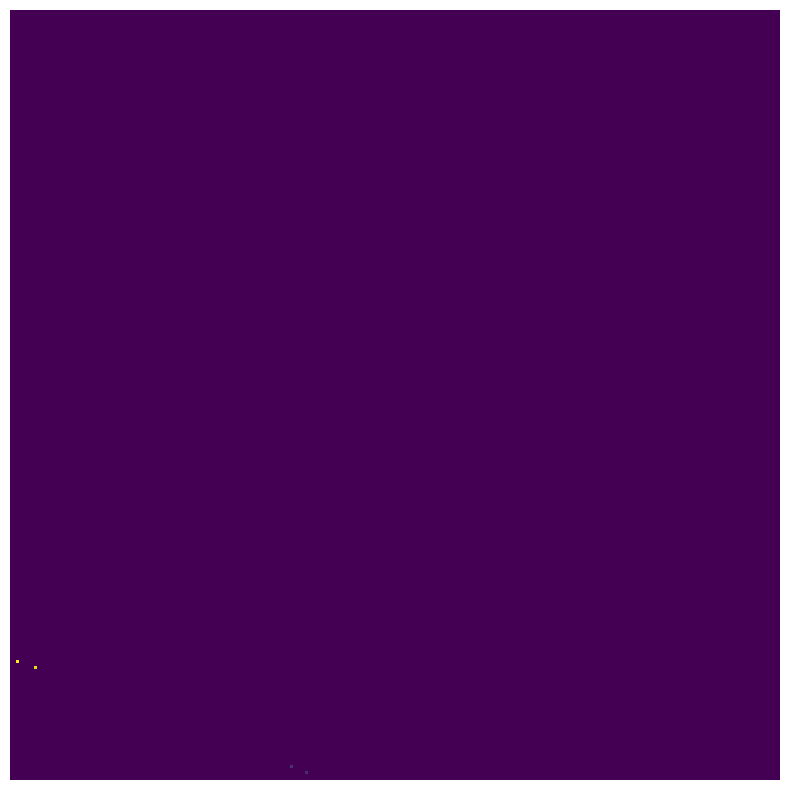

tile shape: (256, 256) s_src: (slice(0, 192, None), slice(64, 192, None)) s_dst: (slice(0, 192, None), slice(192, 320, None))


<ipython-input-7-7d31fbf237ec>:4: RuntimeWarning: invalid value encountered in true_divide
  scaled_img = (mask - np.min(mask)) / (np.amax(mask) - np.amin(mask))


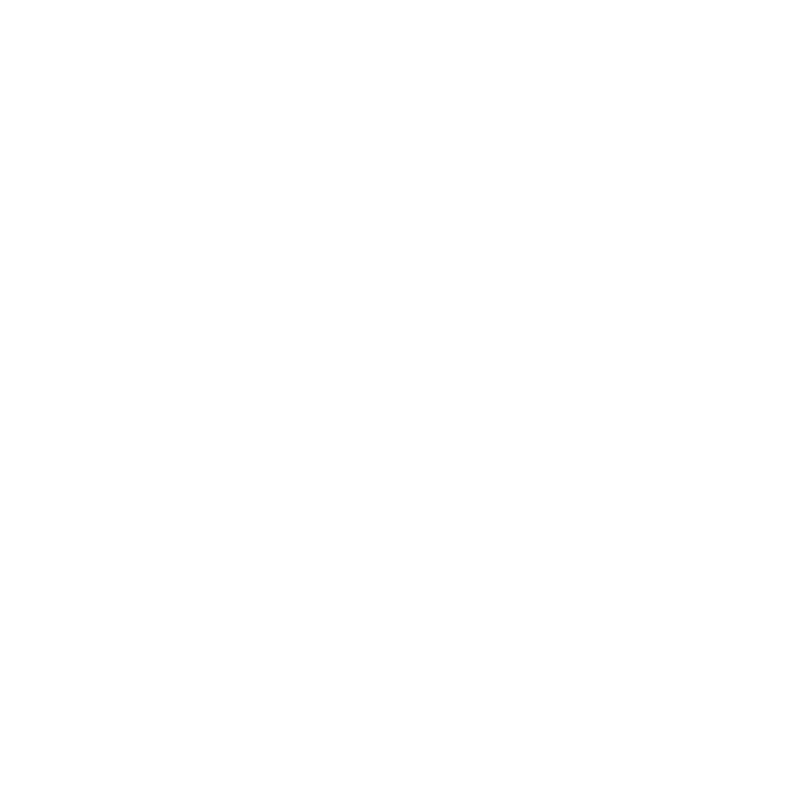

tile shape: (256, 256) s_src: (slice(0, 192, None), slice(64, 192, None)) s_dst: (slice(0, 192, None), slice(320, 448, None))


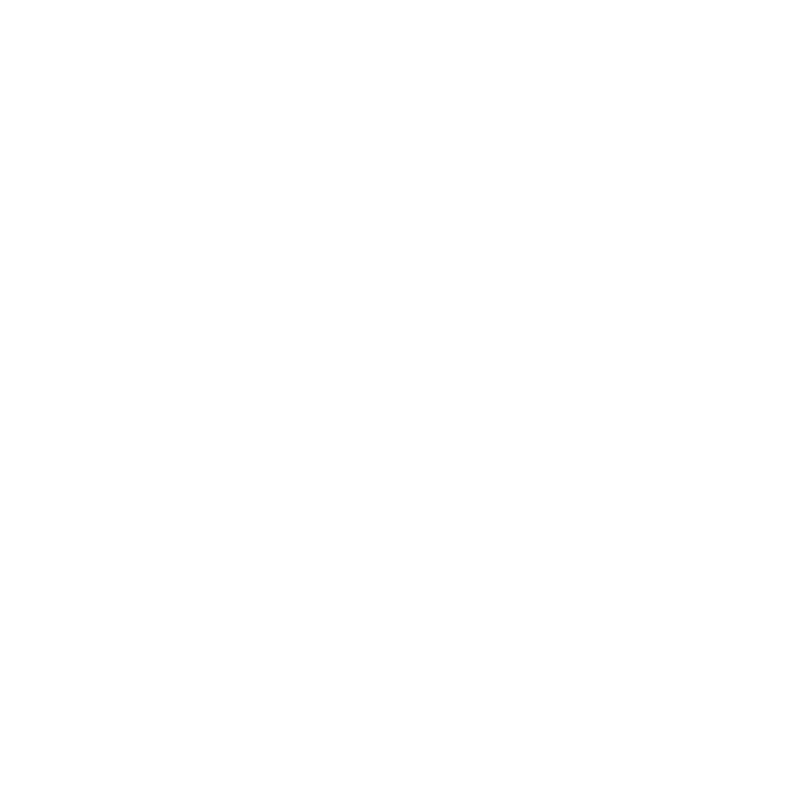

tile shape: (256, 256) s_src: (slice(0, 192, None), slice(64, 192, None)) s_dst: (slice(0, 192, None), slice(448, 576, None))


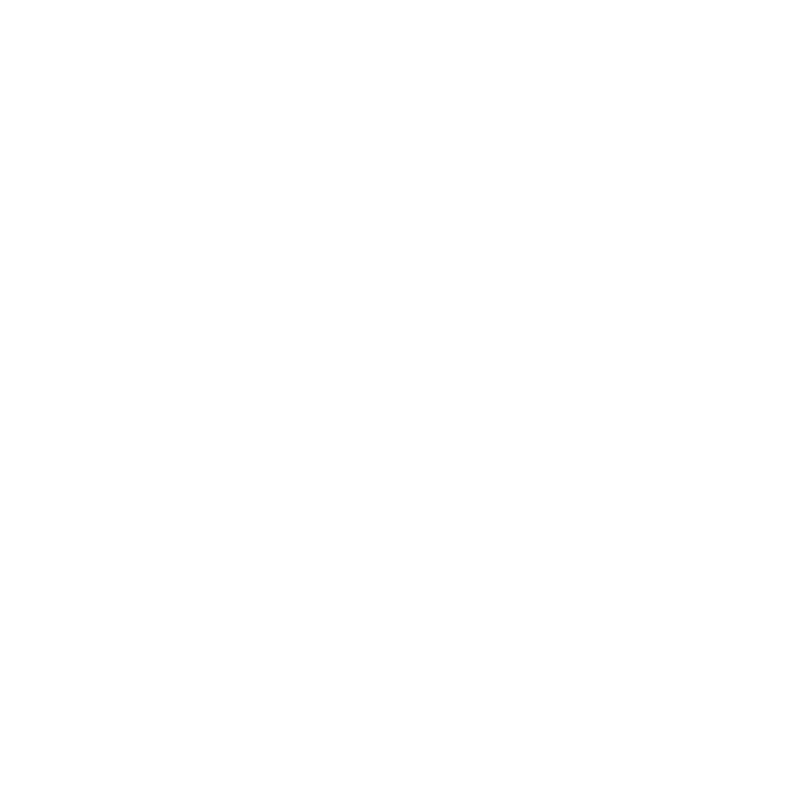

tile shape: (256, 256) s_src: (slice(0, 192, None), slice(64, 192, None)) s_dst: (slice(0, 192, None), slice(576, 704, None))


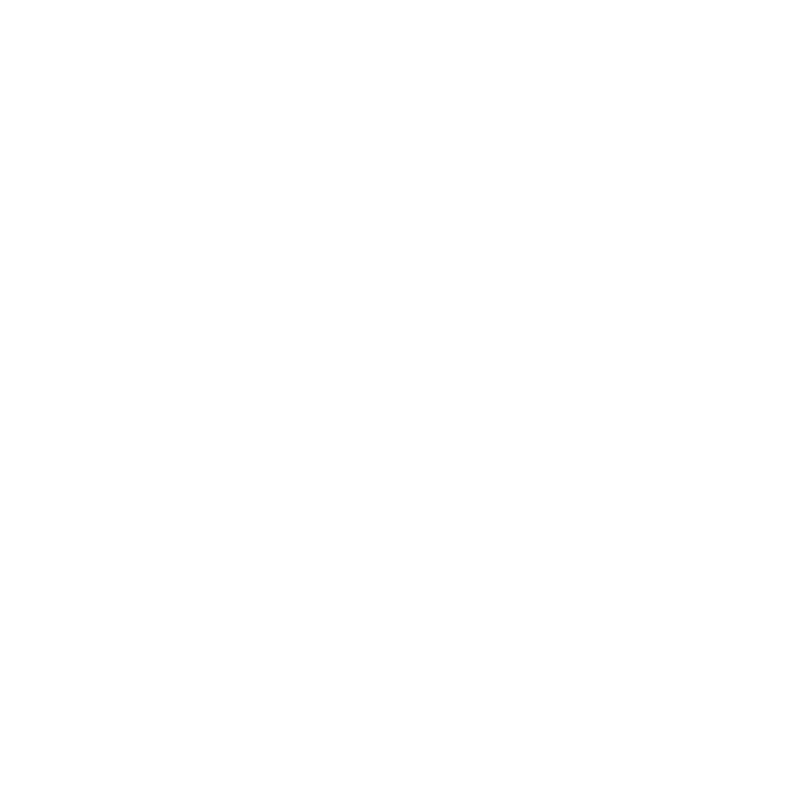

tile shape: (256, 256) s_src: (slice(0, 192, None), slice(64, 192, None)) s_dst: (slice(0, 192, None), slice(704, 832, None))


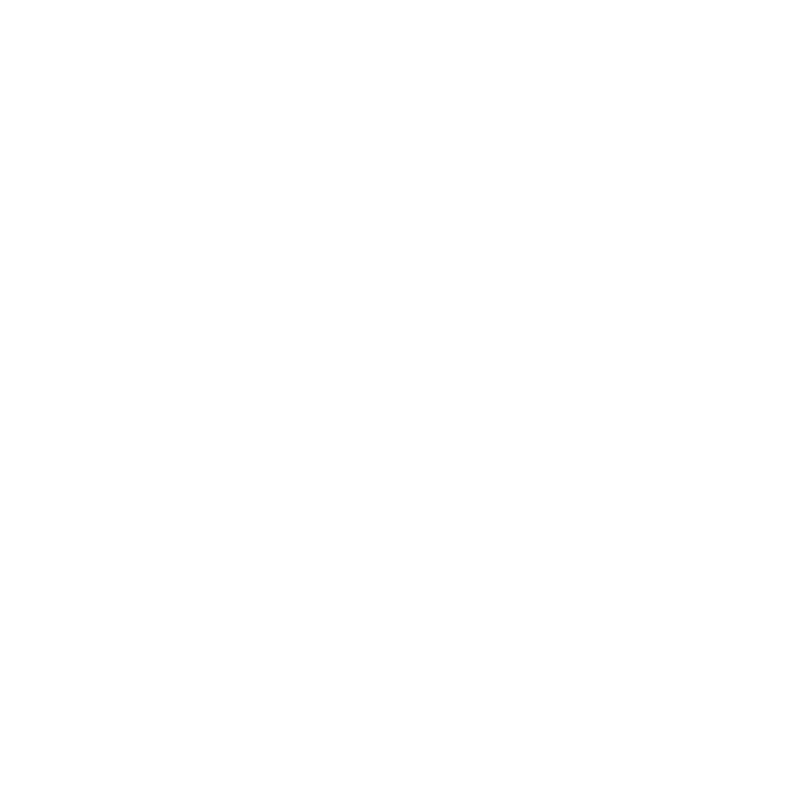

tile shape: (256, 256) s_src: (slice(0, 192, None), slice(64, 256, None)) s_dst: (slice(0, 192, None), slice(832, 1024, None))


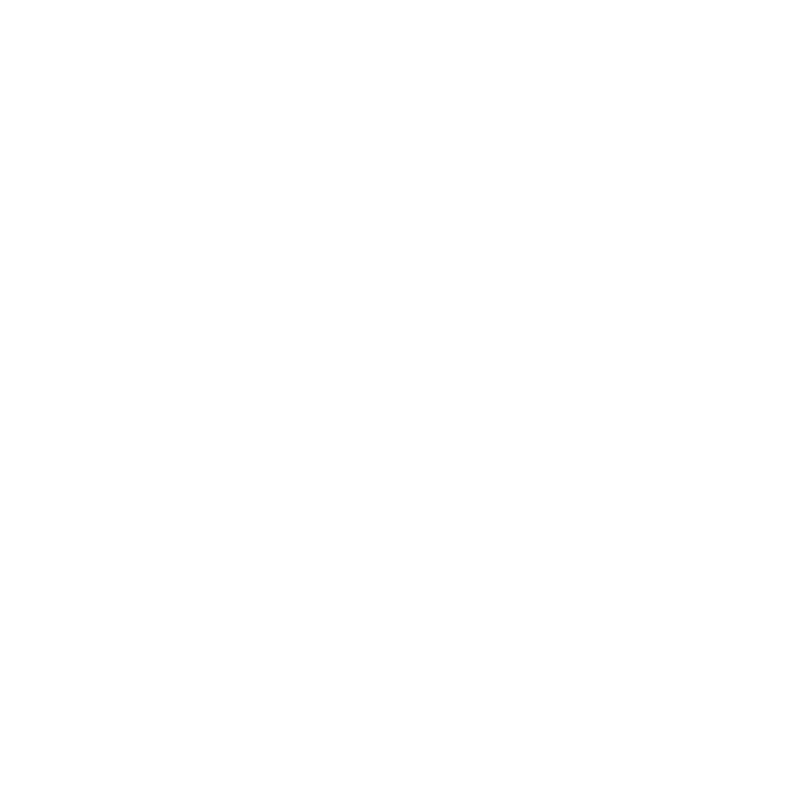

tile shape: (256, 256) s_src: (slice(64, 192, None), slice(0, 192, None)) s_dst: (slice(192, 320, None), slice(0, 192, None))


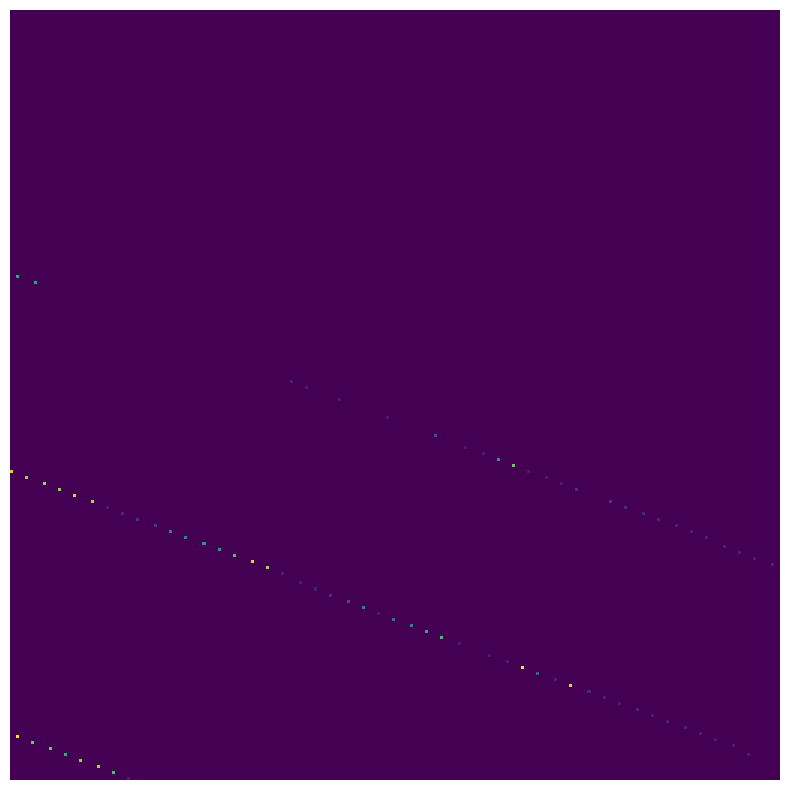

tile shape: (256, 256) s_src: (slice(64, 192, None), slice(64, 192, None)) s_dst: (slice(192, 320, None), slice(192, 320, None))


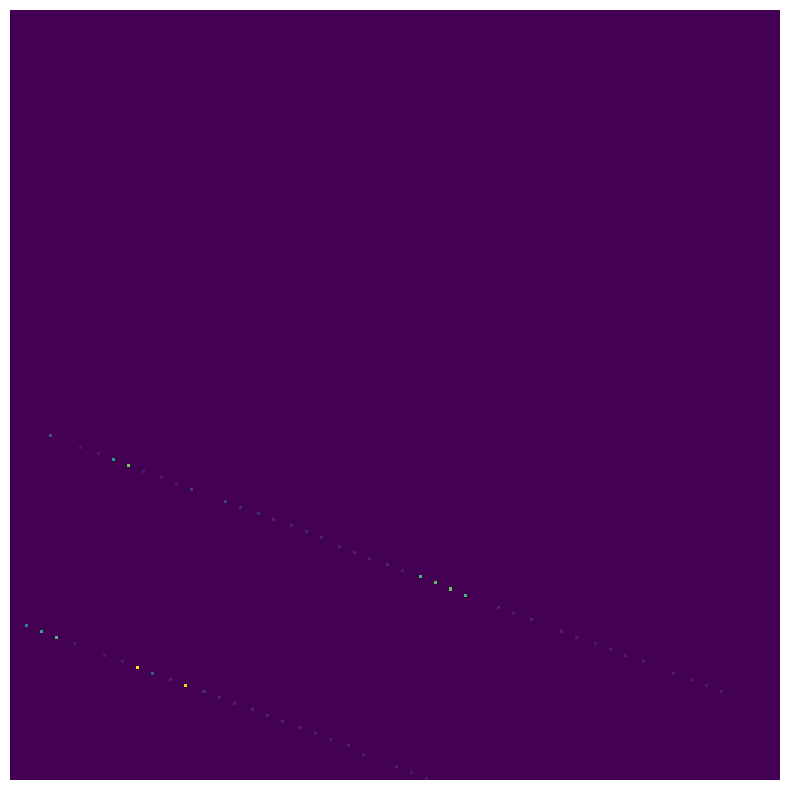

tile shape: (256, 256) s_src: (slice(64, 192, None), slice(64, 192, None)) s_dst: (slice(192, 320, None), slice(320, 448, None))


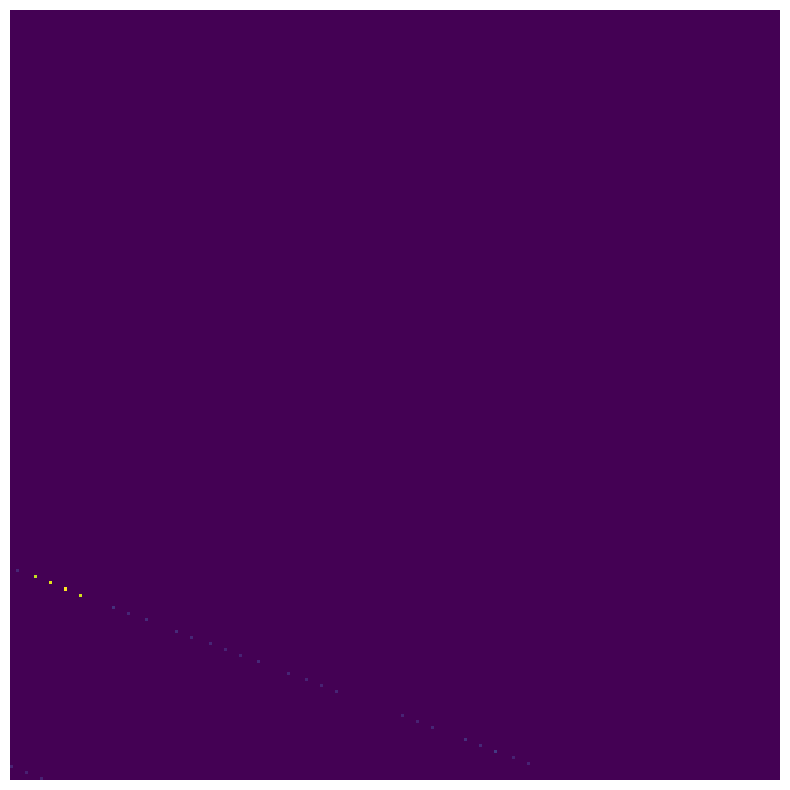

tile shape: (256, 256) s_src: (slice(64, 192, None), slice(64, 192, None)) s_dst: (slice(192, 320, None), slice(448, 576, None))


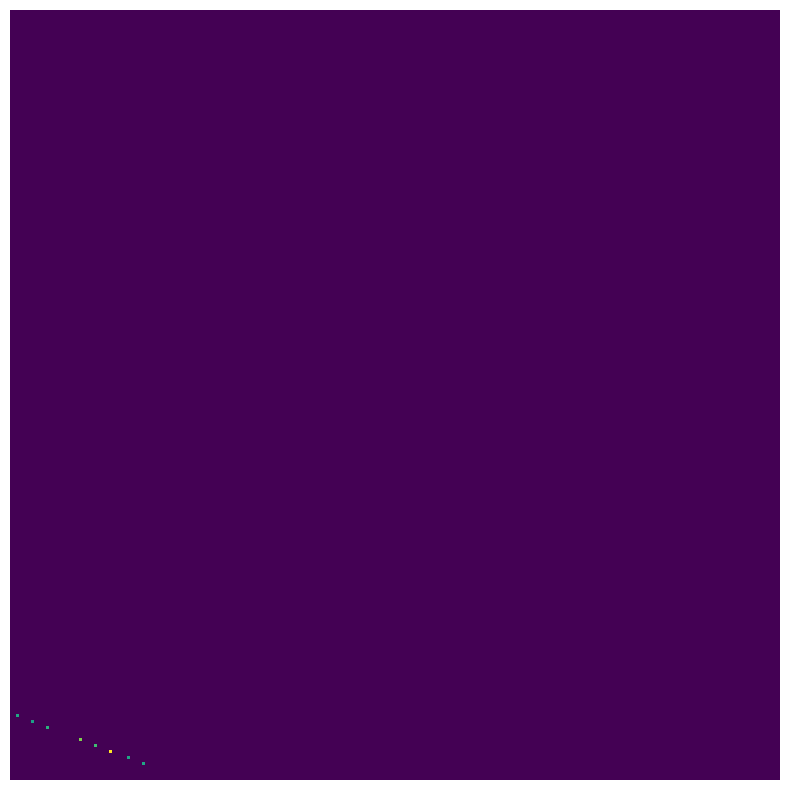

tile shape: (256, 256) s_src: (slice(64, 192, None), slice(64, 192, None)) s_dst: (slice(192, 320, None), slice(576, 704, None))


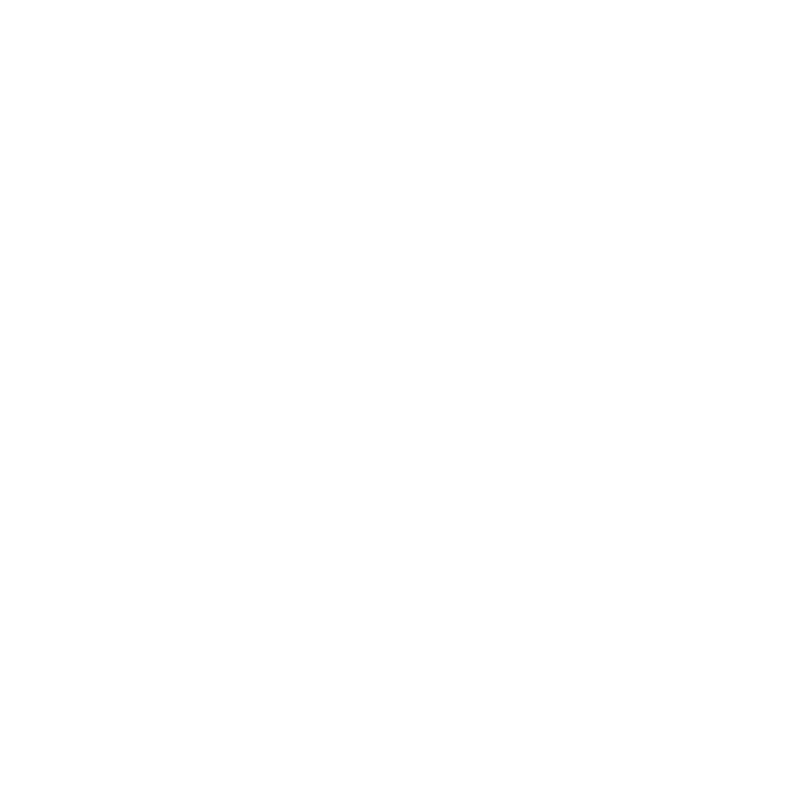

tile shape: (256, 256) s_src: (slice(64, 192, None), slice(64, 192, None)) s_dst: (slice(192, 320, None), slice(704, 832, None))


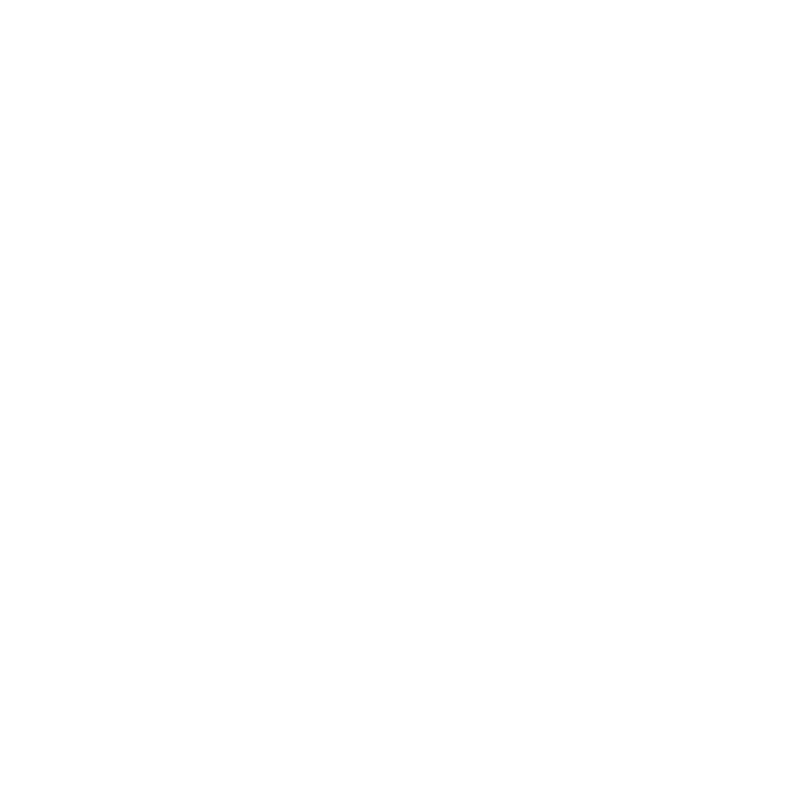

tile shape: (256, 256) s_src: (slice(64, 192, None), slice(64, 256, None)) s_dst: (slice(192, 320, None), slice(832, 1024, None))


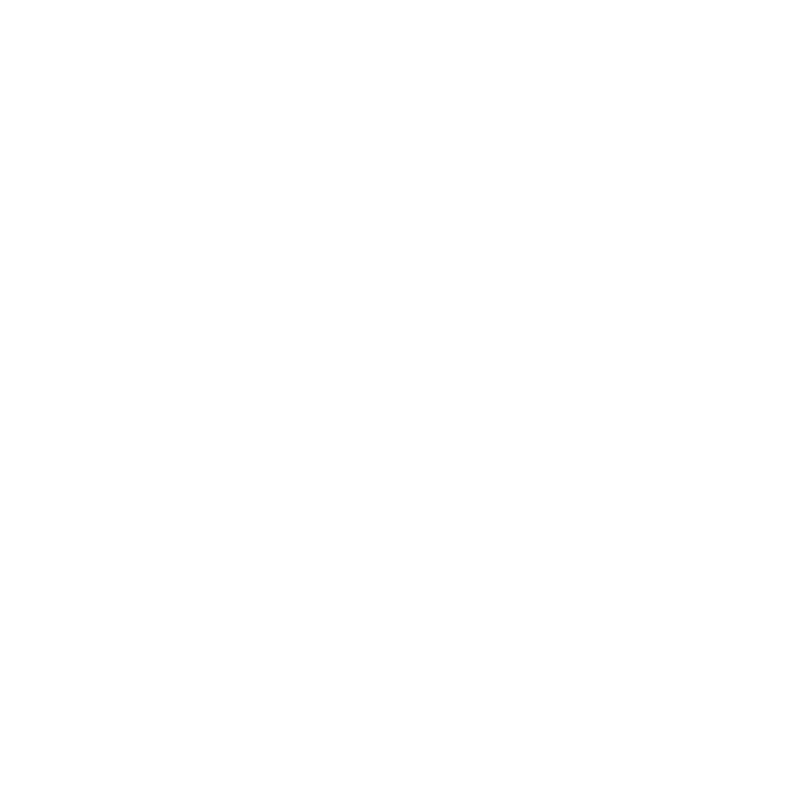

tile shape: (256, 256) s_src: (slice(64, 192, None), slice(0, 192, None)) s_dst: (slice(320, 448, None), slice(0, 192, None))


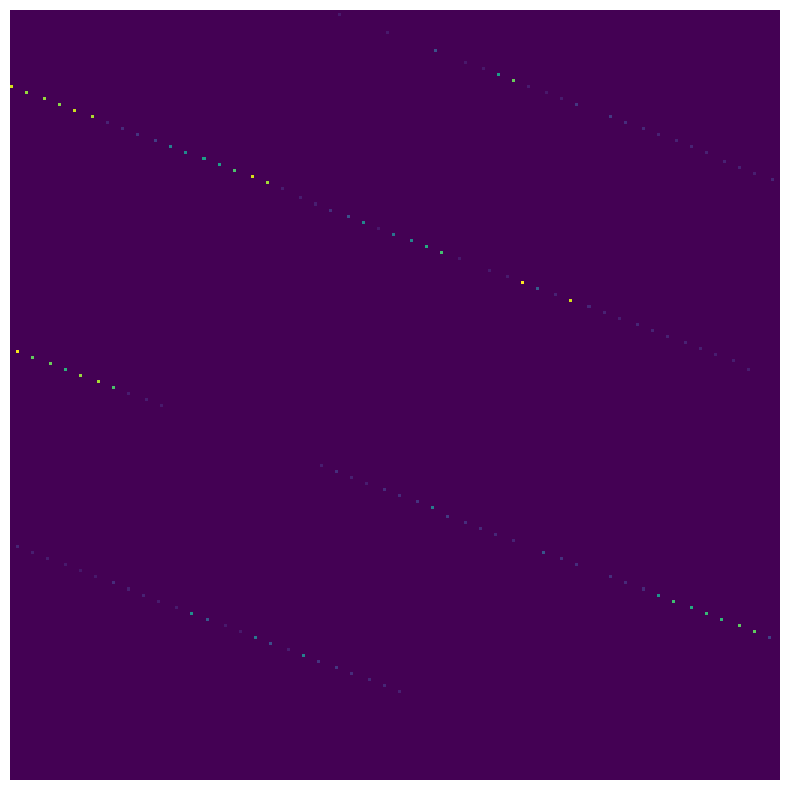

tile shape: (256, 256) s_src: (slice(64, 192, None), slice(64, 192, None)) s_dst: (slice(320, 448, None), slice(192, 320, None))


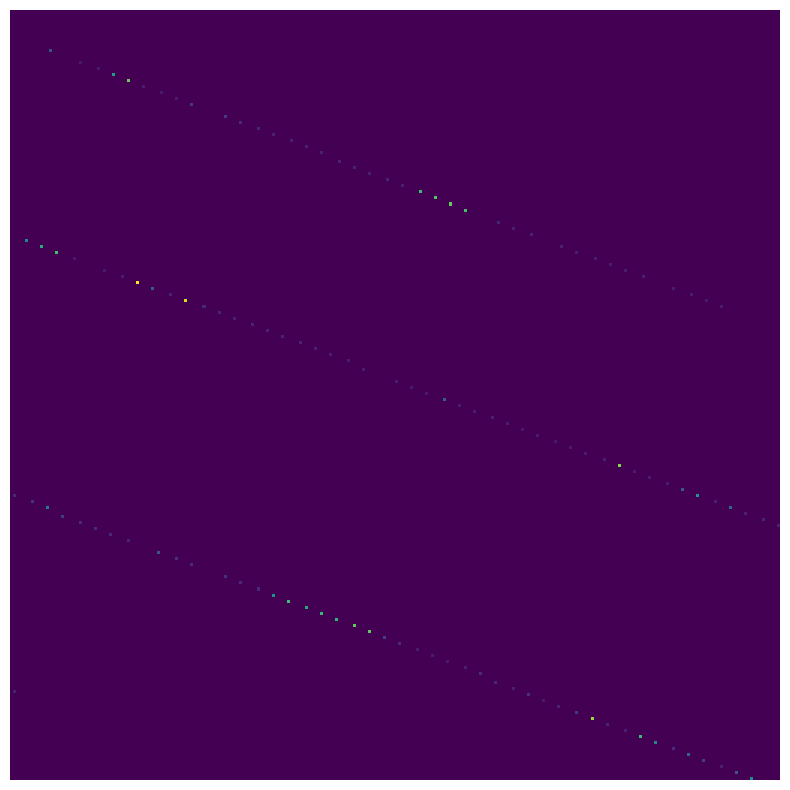

tile shape: (256, 256) s_src: (slice(64, 192, None), slice(64, 192, None)) s_dst: (slice(320, 448, None), slice(320, 448, None))


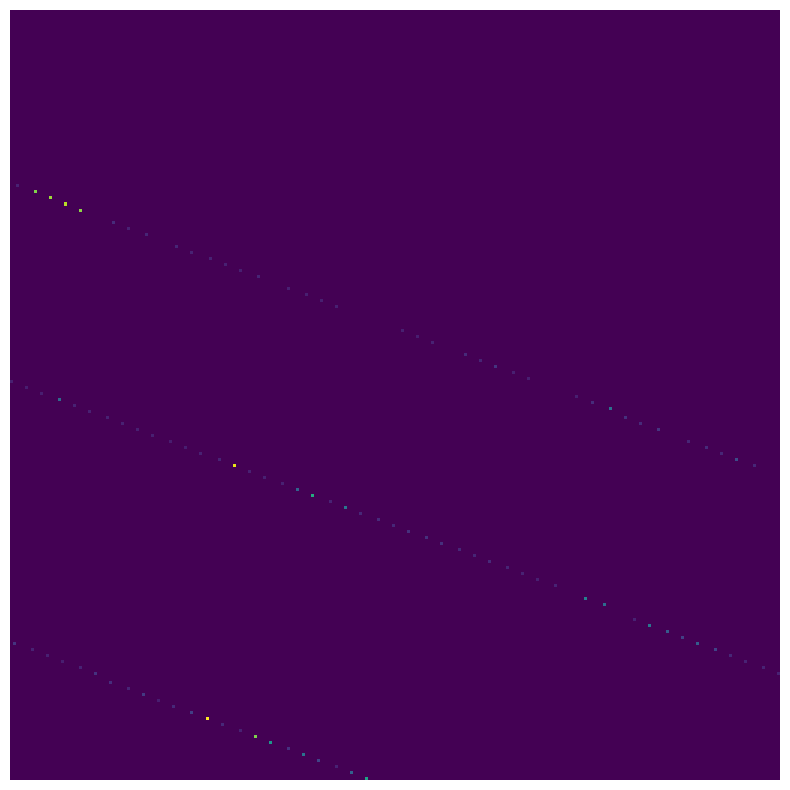

tile shape: (256, 256) s_src: (slice(64, 192, None), slice(64, 192, None)) s_dst: (slice(320, 448, None), slice(448, 576, None))


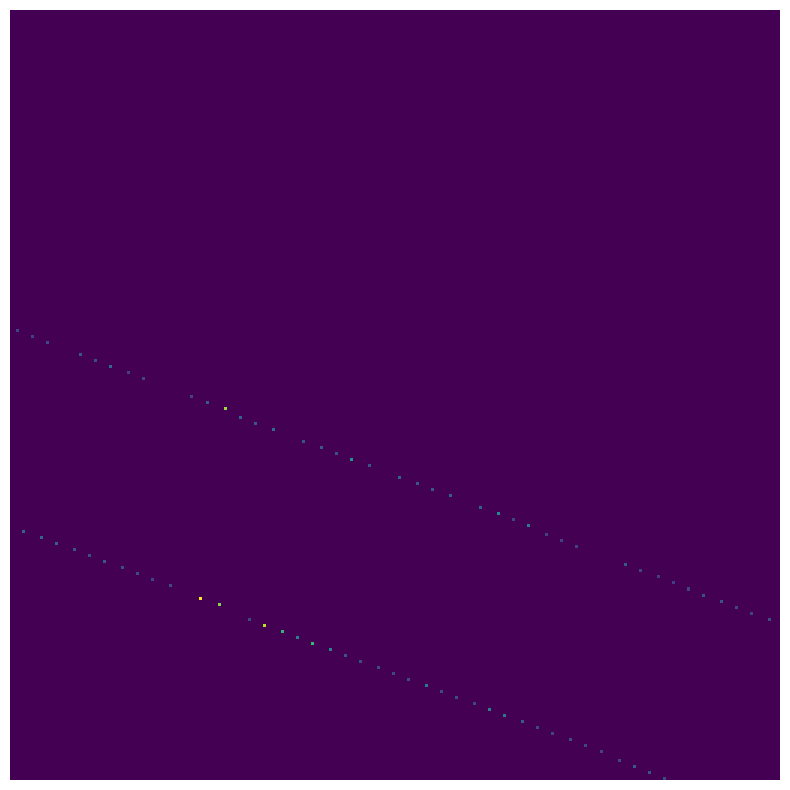

tile shape: (256, 256) s_src: (slice(64, 192, None), slice(64, 192, None)) s_dst: (slice(320, 448, None), slice(576, 704, None))


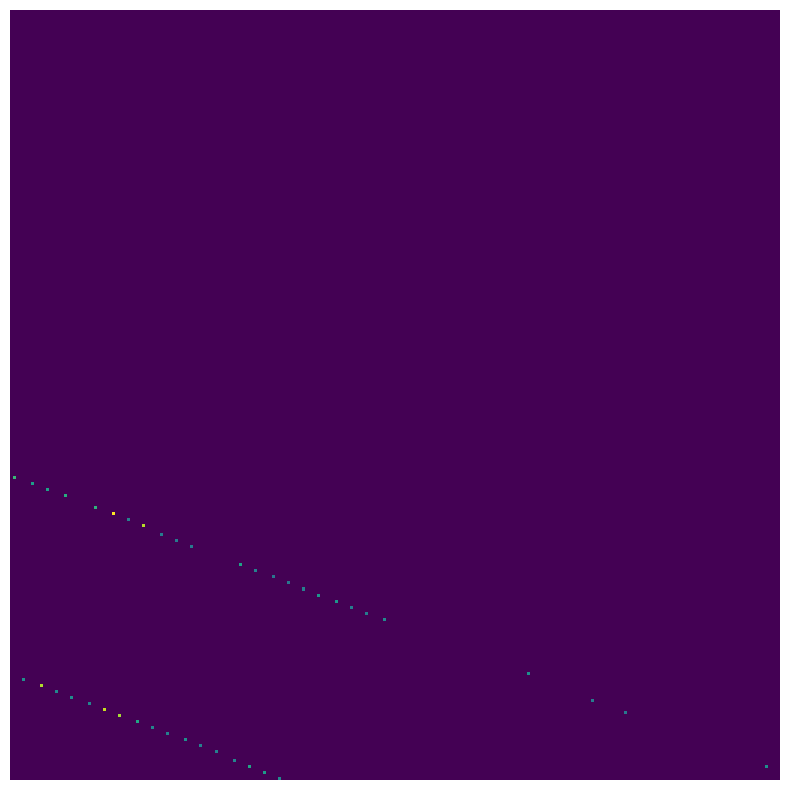

tile shape: (256, 256) s_src: (slice(64, 192, None), slice(64, 192, None)) s_dst: (slice(320, 448, None), slice(704, 832, None))


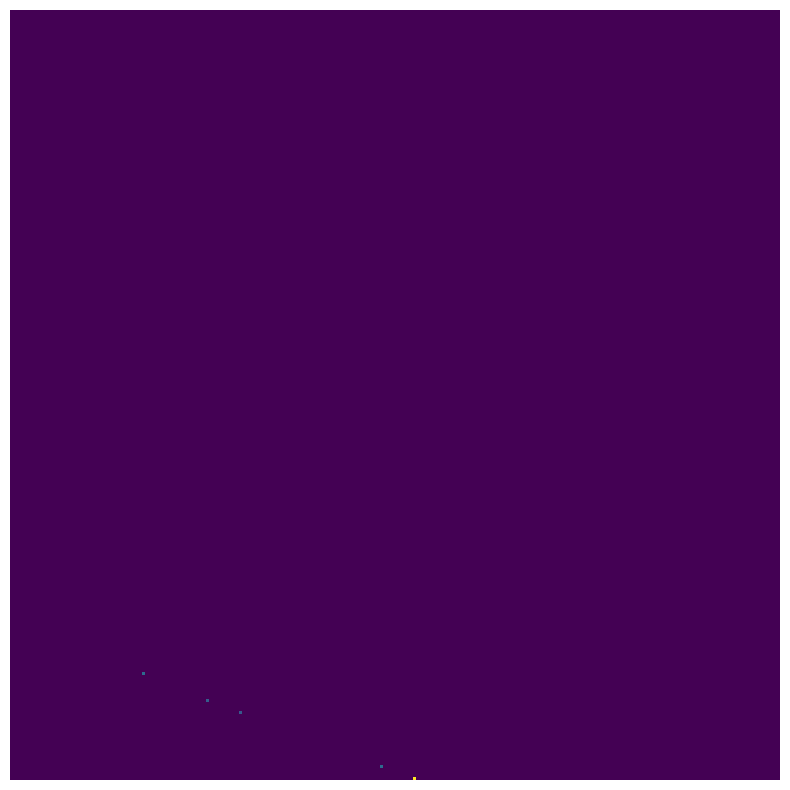

tile shape: (256, 256) s_src: (slice(64, 192, None), slice(64, 256, None)) s_dst: (slice(320, 448, None), slice(832, 1024, None))


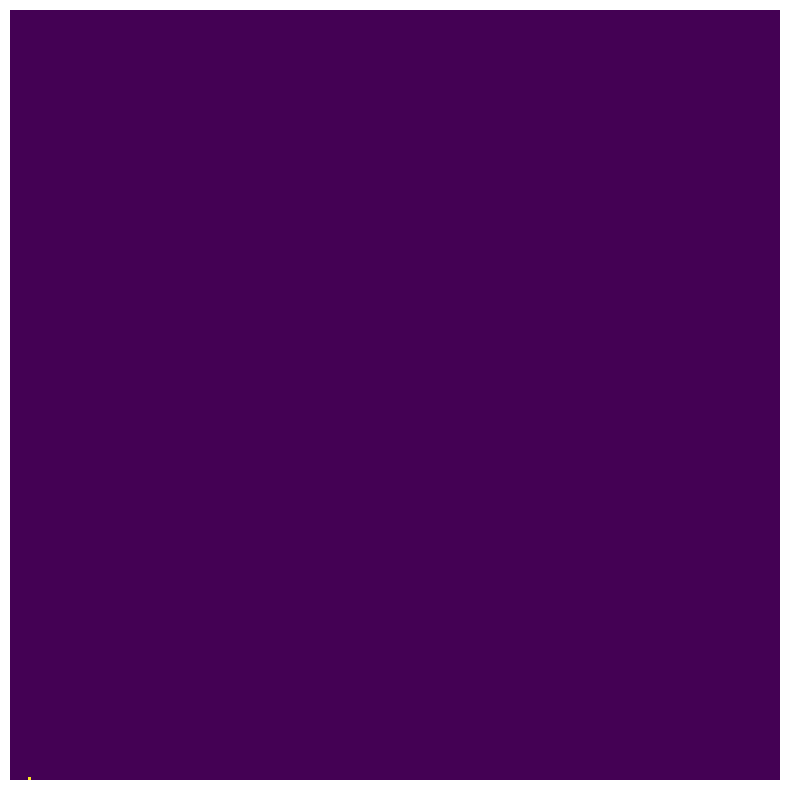

tile shape: (256, 256) s_src: (slice(64, 192, None), slice(0, 192, None)) s_dst: (slice(448, 576, None), slice(0, 192, None))


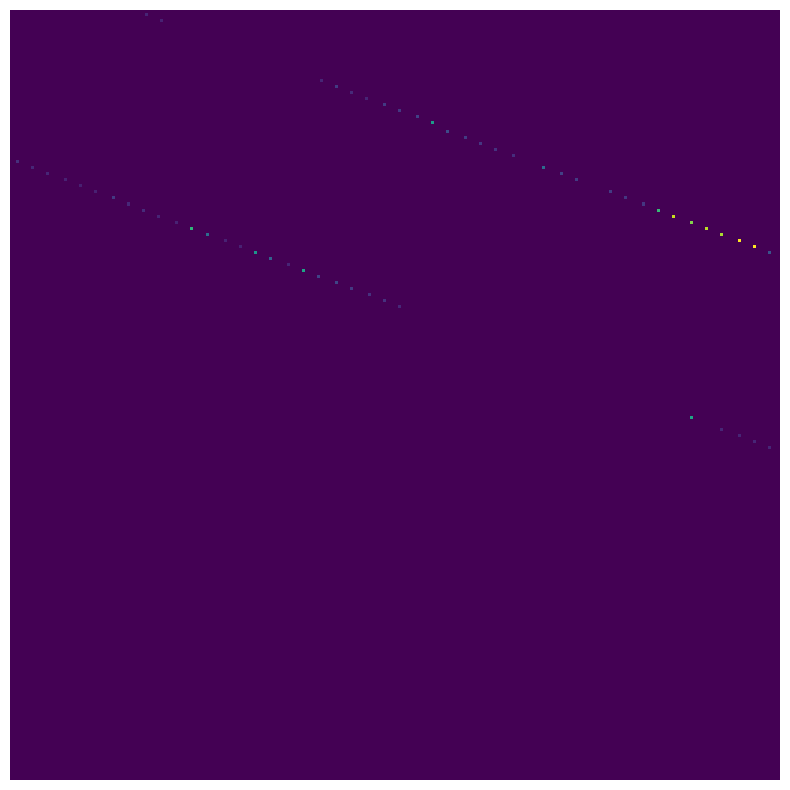

tile shape: (256, 256) s_src: (slice(64, 192, None), slice(64, 192, None)) s_dst: (slice(448, 576, None), slice(192, 320, None))


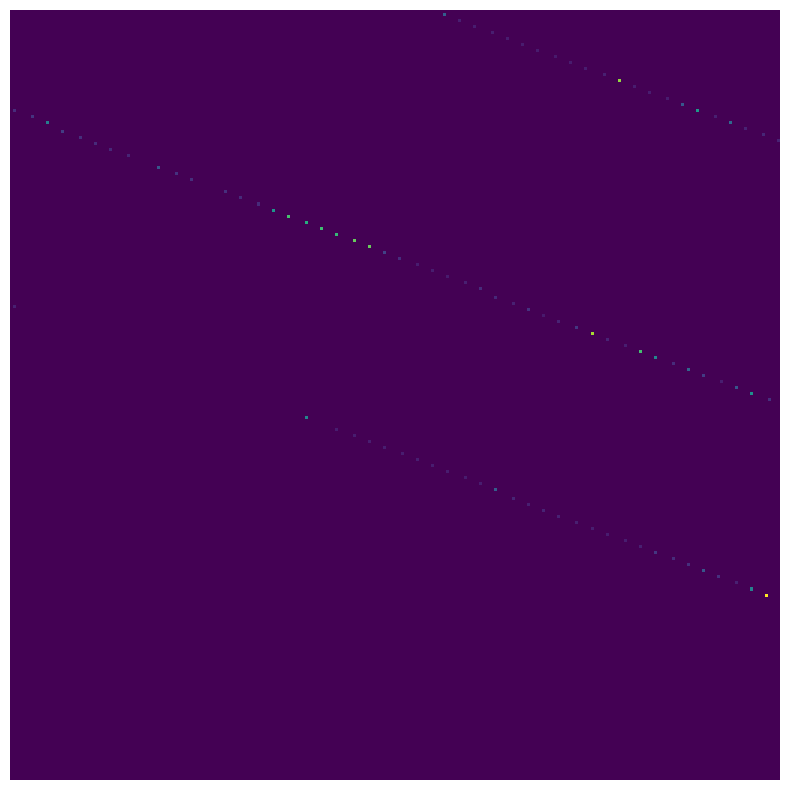

tile shape: (256, 256) s_src: (slice(64, 192, None), slice(64, 192, None)) s_dst: (slice(448, 576, None), slice(320, 448, None))


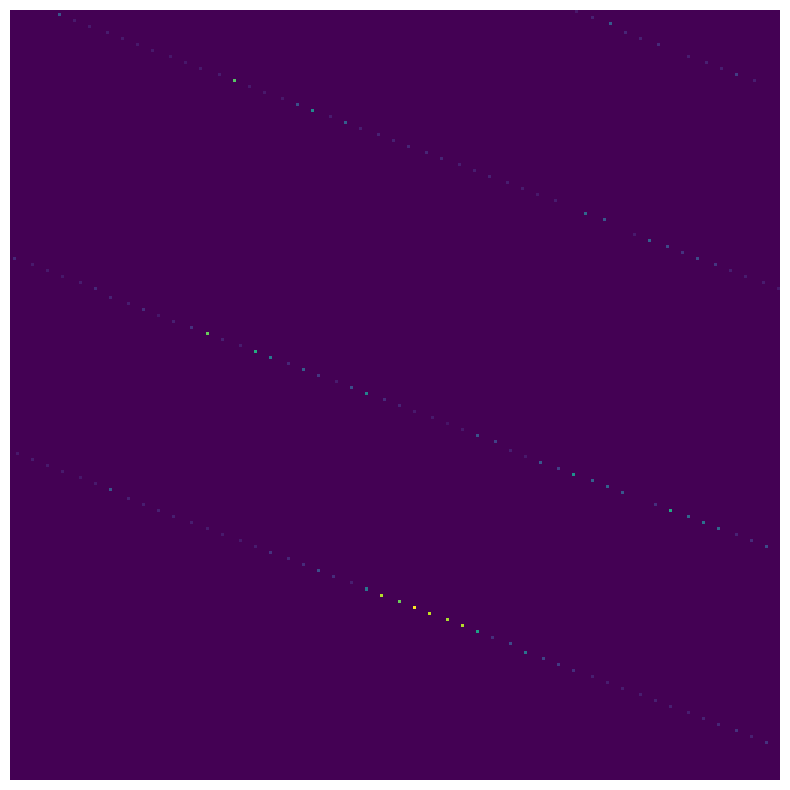

tile shape: (256, 256) s_src: (slice(64, 192, None), slice(64, 192, None)) s_dst: (slice(448, 576, None), slice(448, 576, None))


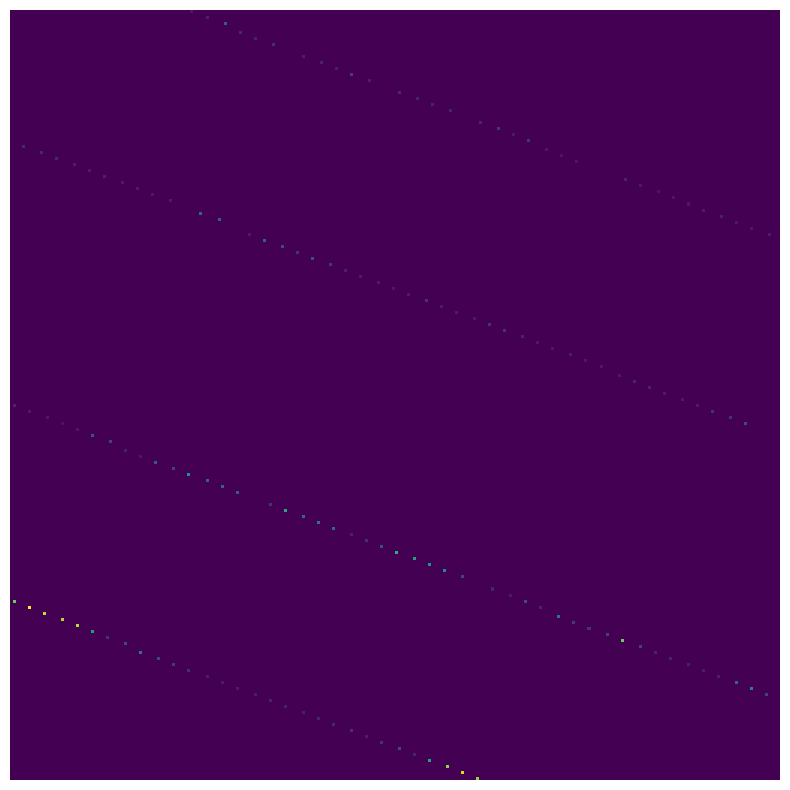

tile shape: (256, 256) s_src: (slice(64, 192, None), slice(64, 192, None)) s_dst: (slice(448, 576, None), slice(576, 704, None))


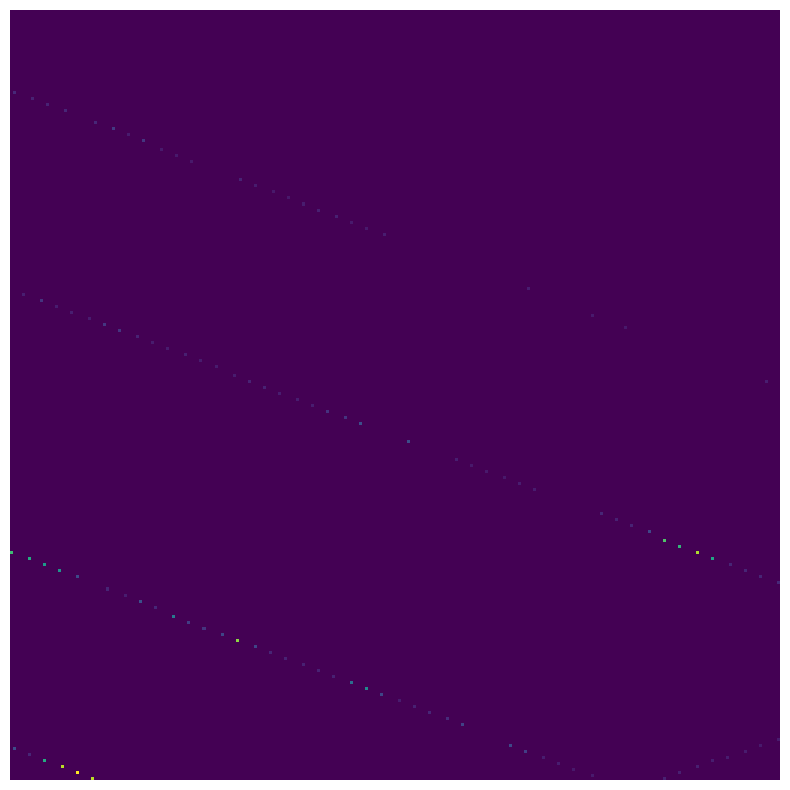

tile shape: (256, 256) s_src: (slice(64, 192, None), slice(64, 192, None)) s_dst: (slice(448, 576, None), slice(704, 832, None))


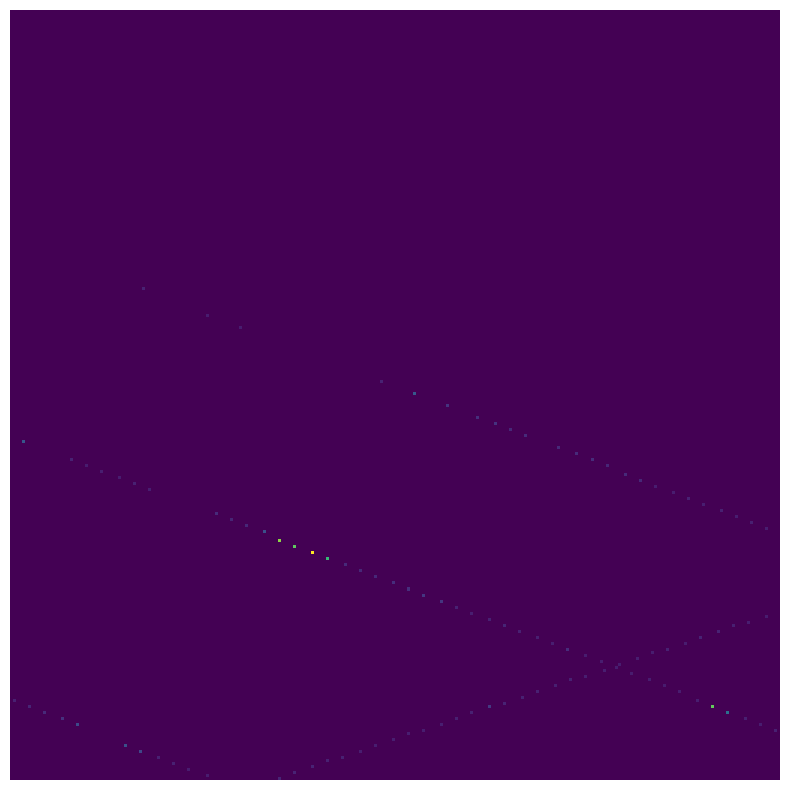

tile shape: (256, 256) s_src: (slice(64, 192, None), slice(64, 256, None)) s_dst: (slice(448, 576, None), slice(832, 1024, None))


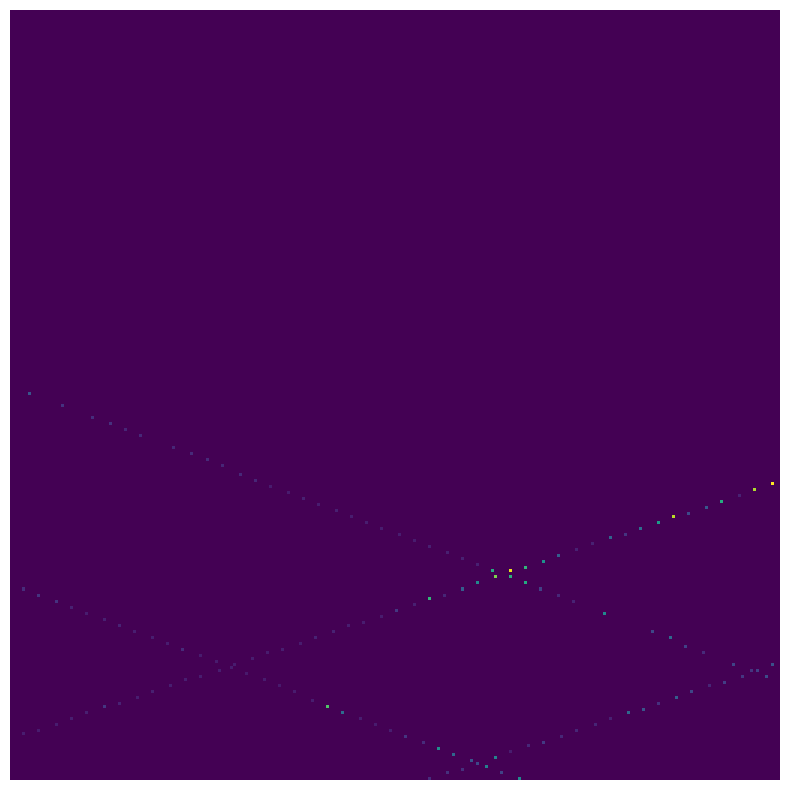

tile shape: (256, 256) s_src: (slice(64, 192, None), slice(0, 192, None)) s_dst: (slice(576, 704, None), slice(0, 192, None))


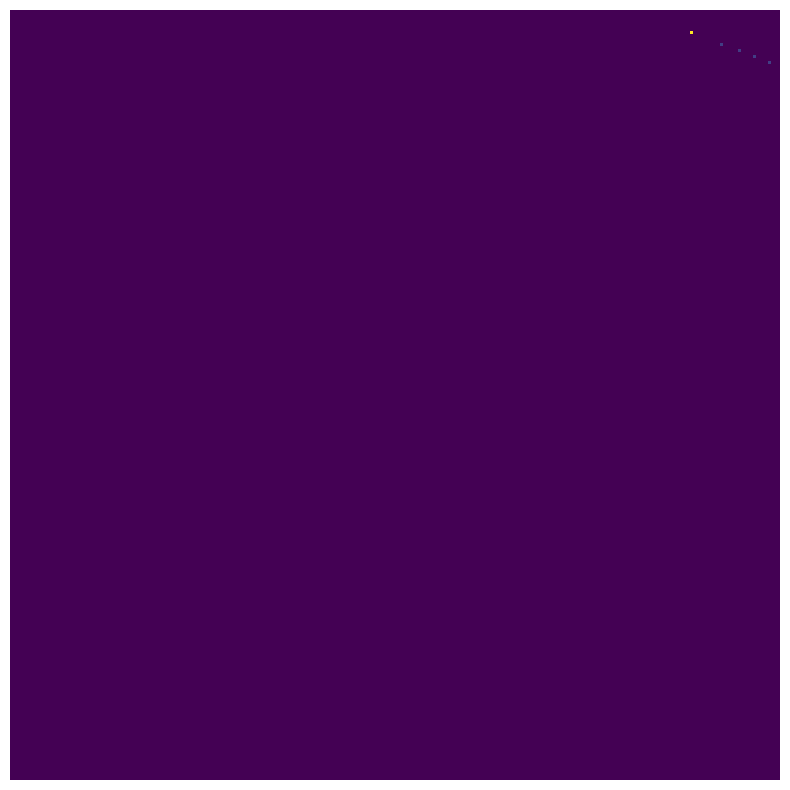

tile shape: (256, 256) s_src: (slice(64, 192, None), slice(64, 192, None)) s_dst: (slice(576, 704, None), slice(192, 320, None))


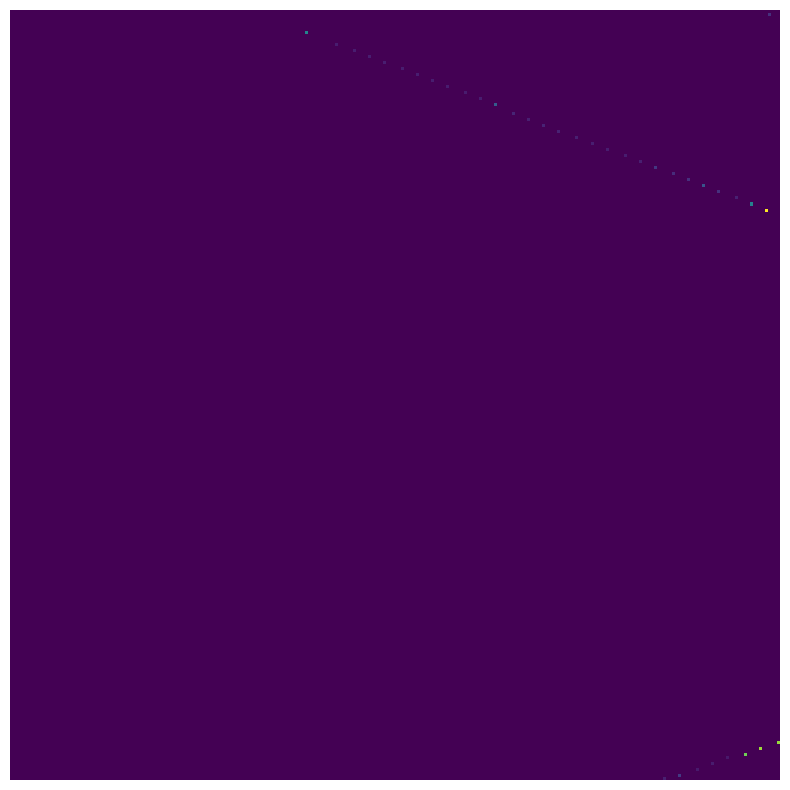

tile shape: (256, 256) s_src: (slice(64, 192, None), slice(64, 192, None)) s_dst: (slice(576, 704, None), slice(320, 448, None))


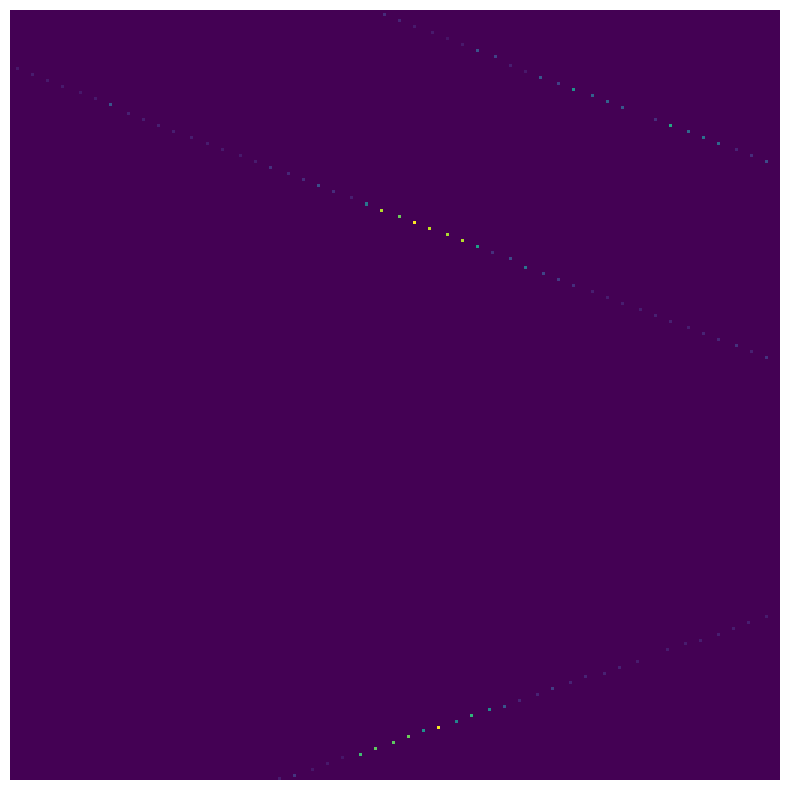

tile shape: (256, 256) s_src: (slice(64, 192, None), slice(64, 192, None)) s_dst: (slice(576, 704, None), slice(448, 576, None))


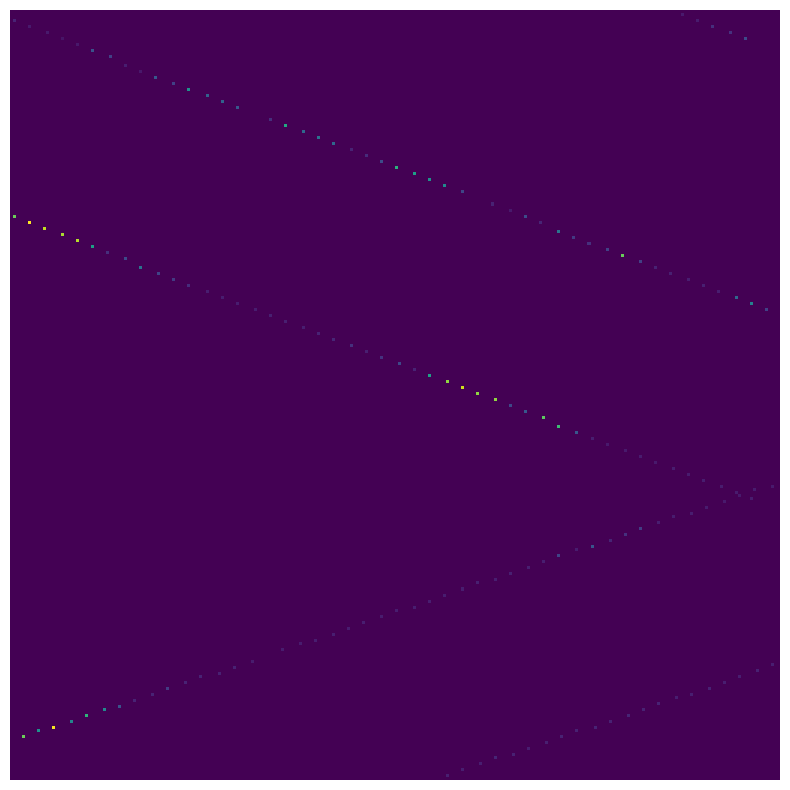

tile shape: (256, 256) s_src: (slice(64, 192, None), slice(64, 192, None)) s_dst: (slice(576, 704, None), slice(576, 704, None))


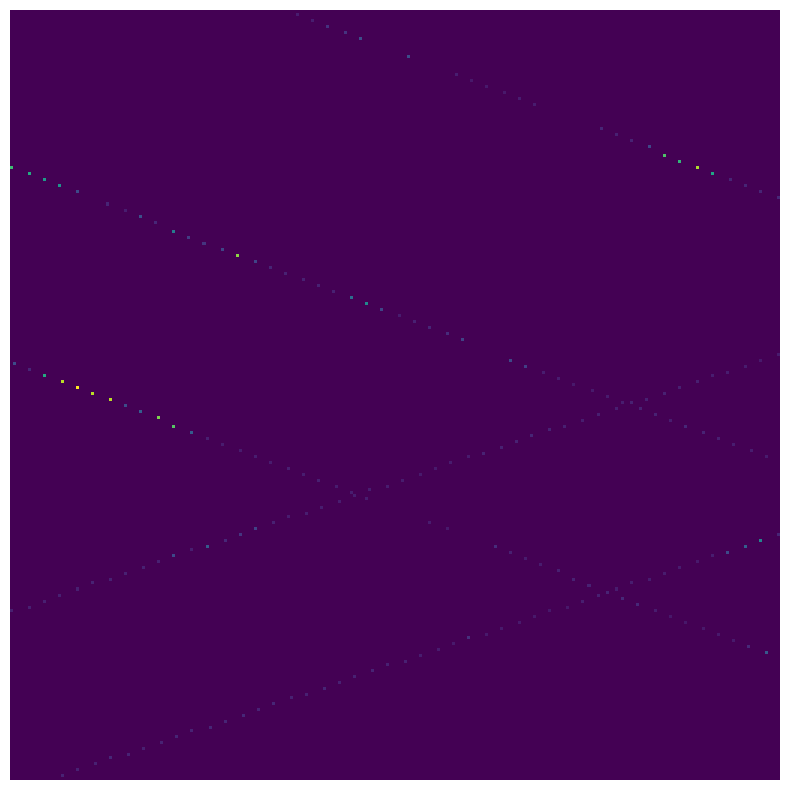

tile shape: (256, 256) s_src: (slice(64, 192, None), slice(64, 192, None)) s_dst: (slice(576, 704, None), slice(704, 832, None))


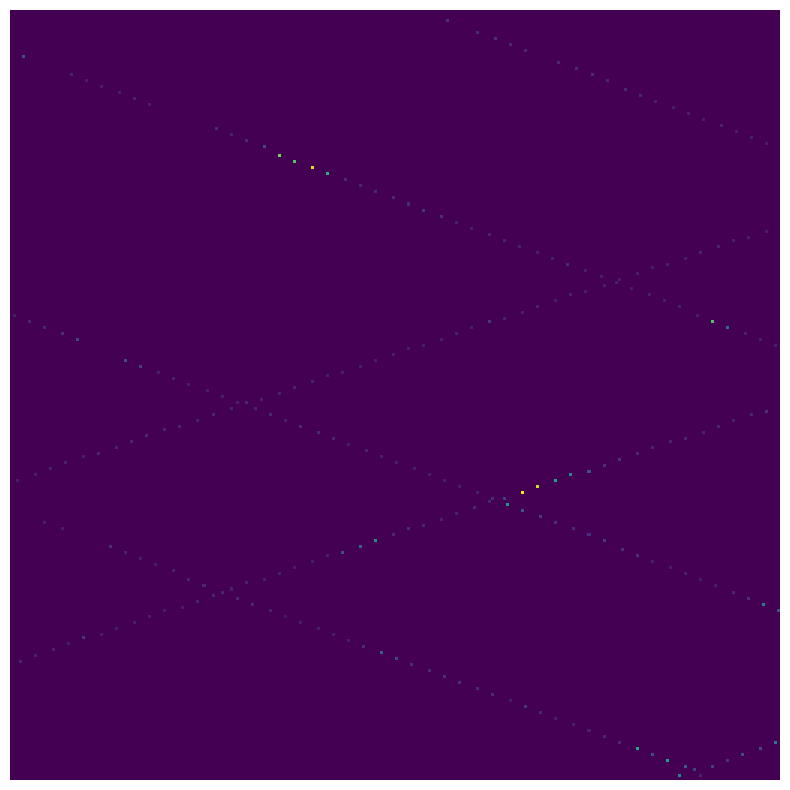

tile shape: (256, 256) s_src: (slice(64, 192, None), slice(64, 256, None)) s_dst: (slice(576, 704, None), slice(832, 1024, None))


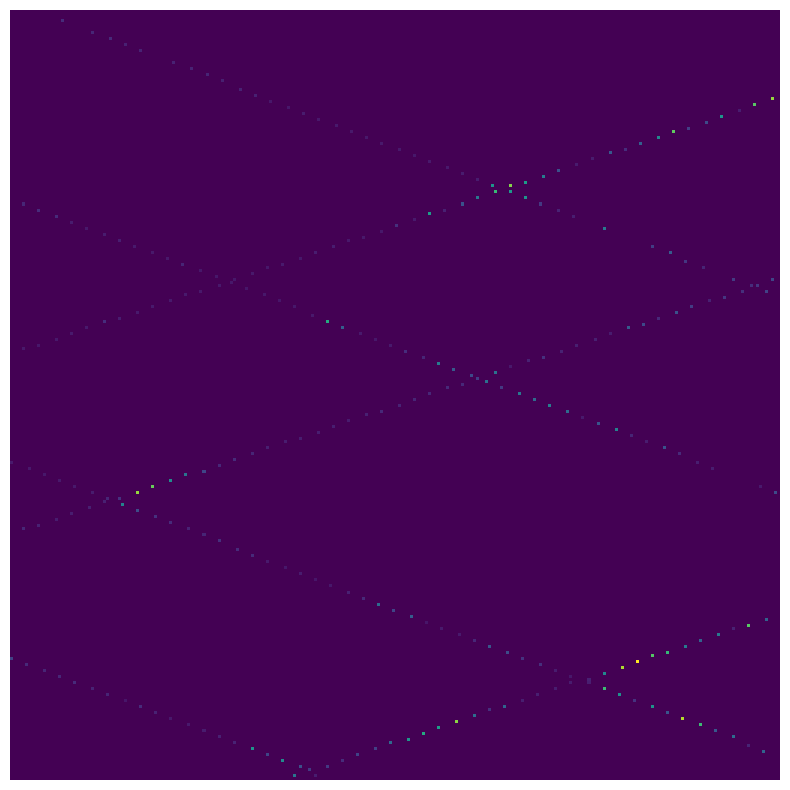

tile shape: (256, 256) s_src: (slice(64, 192, None), slice(0, 192, None)) s_dst: (slice(704, 832, None), slice(0, 192, None))


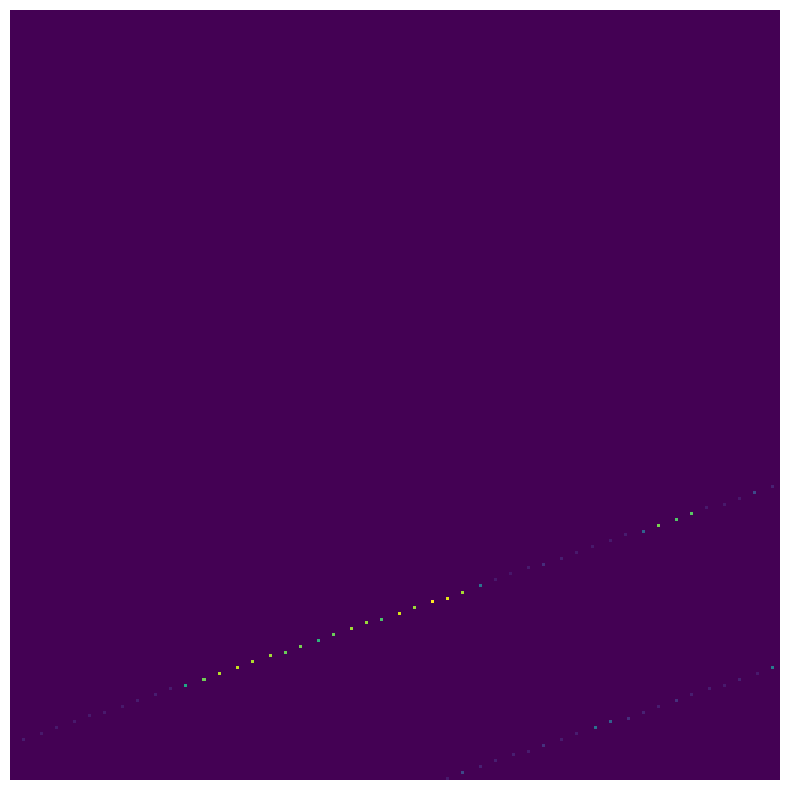

tile shape: (256, 256) s_src: (slice(64, 192, None), slice(64, 192, None)) s_dst: (slice(704, 832, None), slice(192, 320, None))


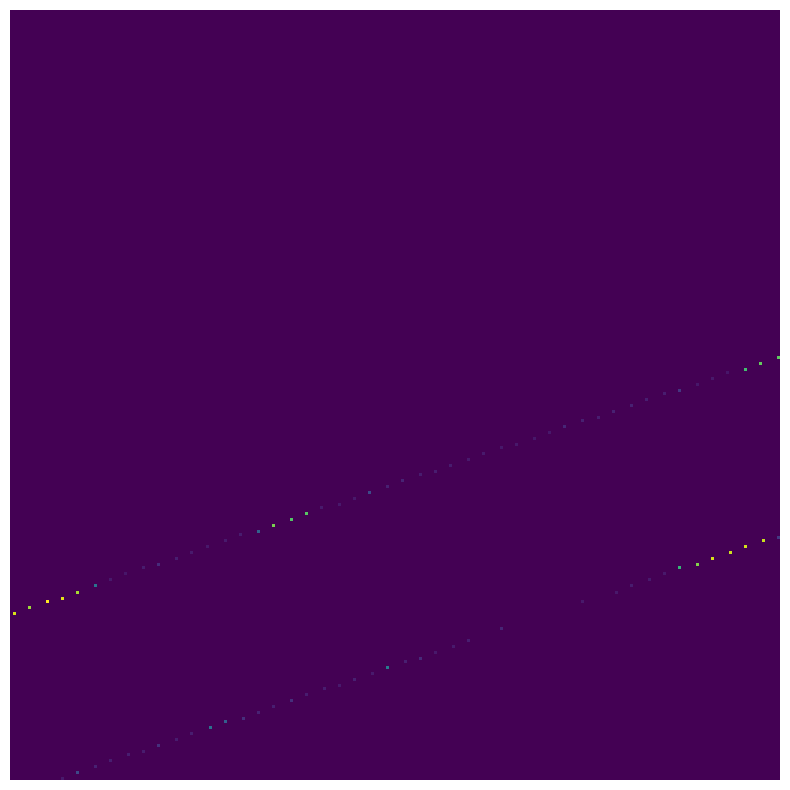

tile shape: (256, 256) s_src: (slice(64, 192, None), slice(64, 192, None)) s_dst: (slice(704, 832, None), slice(320, 448, None))


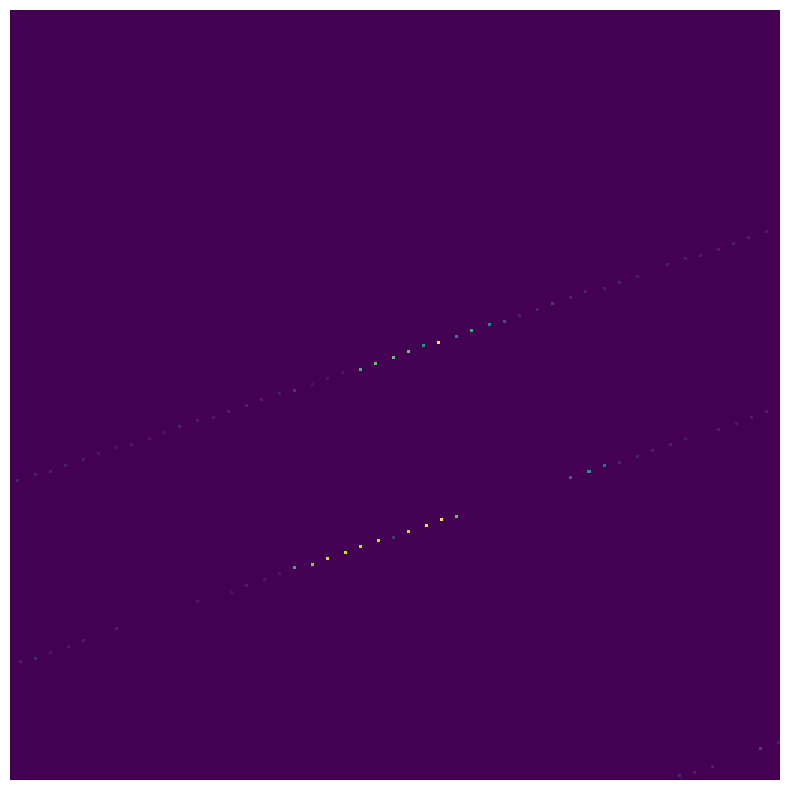

tile shape: (256, 256) s_src: (slice(64, 192, None), slice(64, 192, None)) s_dst: (slice(704, 832, None), slice(448, 576, None))


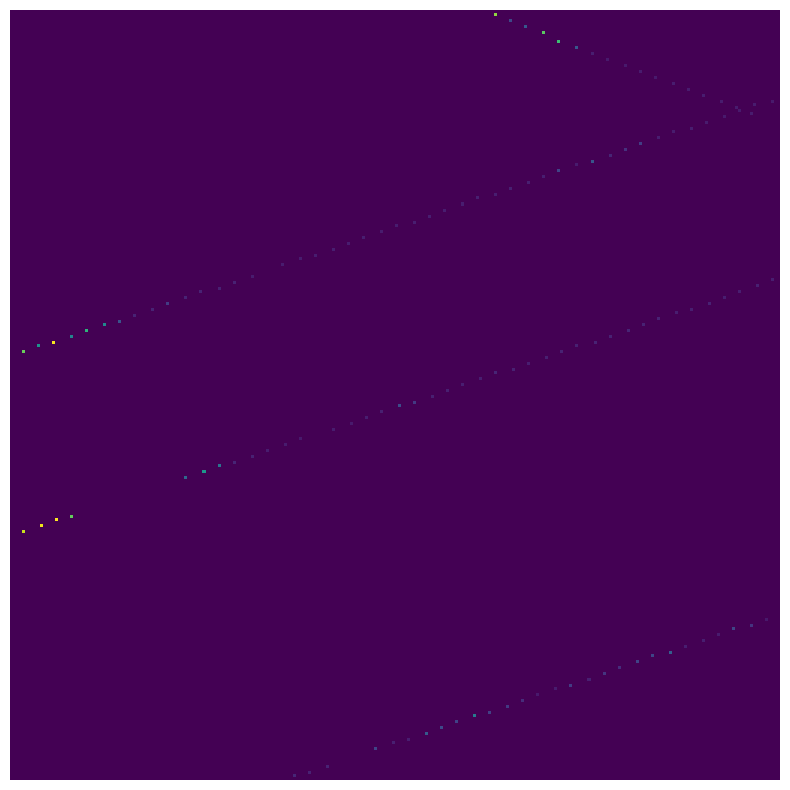

tile shape: (256, 256) s_src: (slice(64, 192, None), slice(64, 192, None)) s_dst: (slice(704, 832, None), slice(576, 704, None))


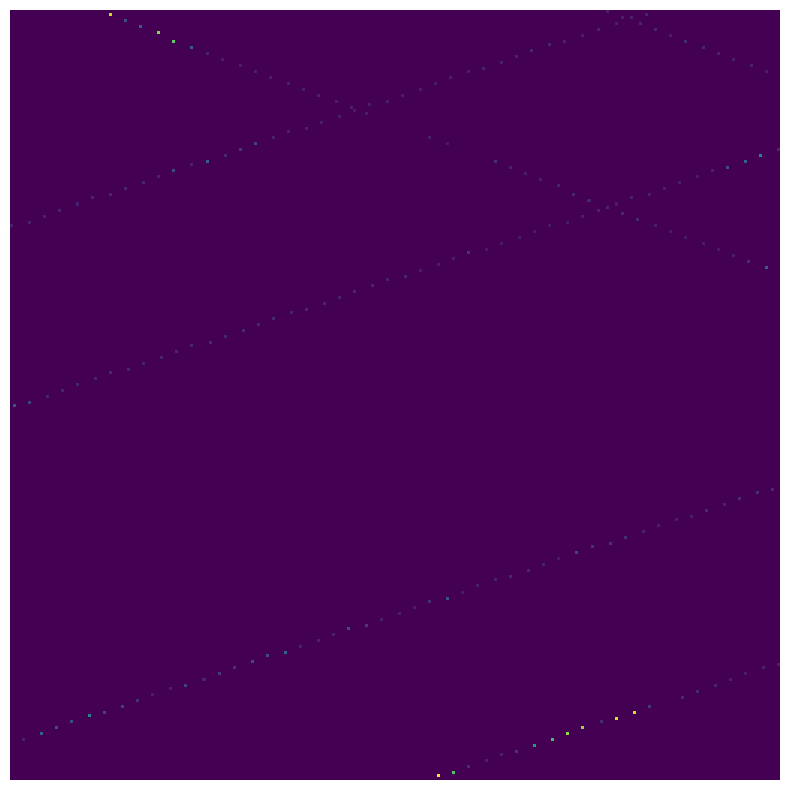

tile shape: (256, 256) s_src: (slice(64, 192, None), slice(64, 192, None)) s_dst: (slice(704, 832, None), slice(704, 832, None))


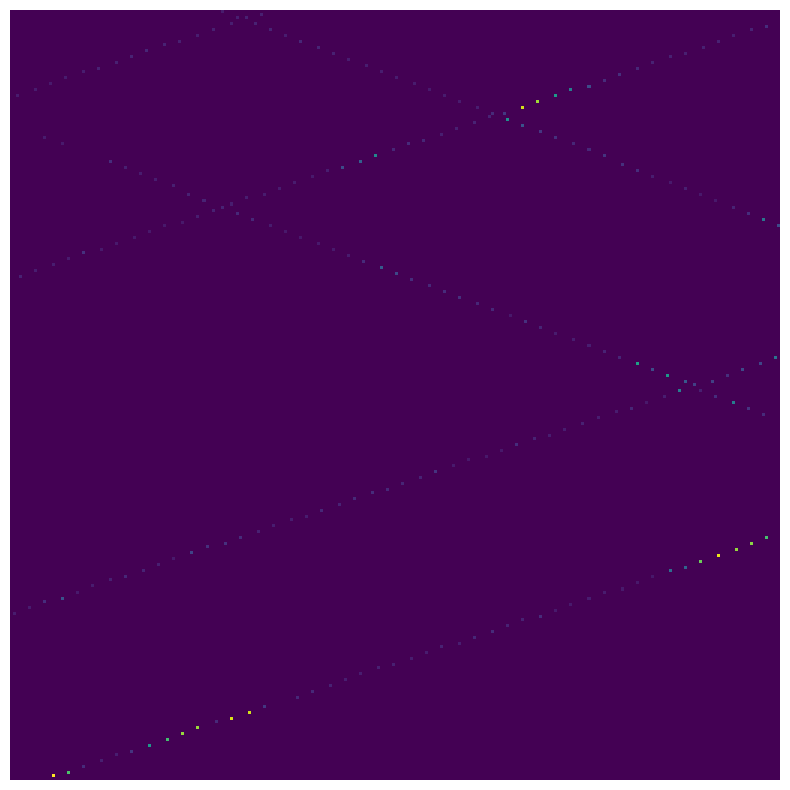

tile shape: (256, 256) s_src: (slice(64, 192, None), slice(64, 256, None)) s_dst: (slice(704, 832, None), slice(832, 1024, None))


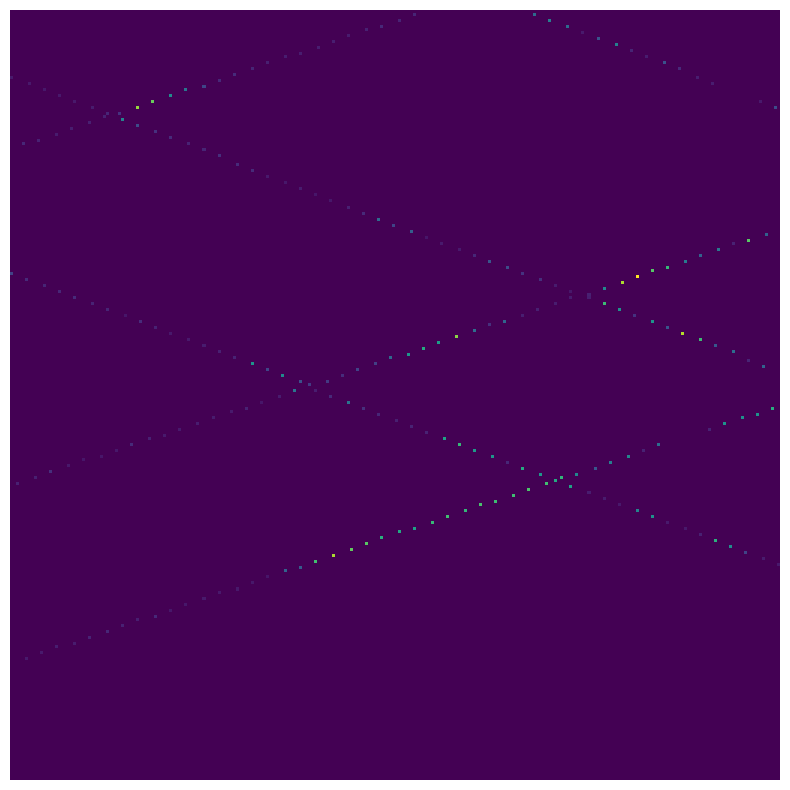

tile shape: (256, 256) s_src: (slice(64, 256, None), slice(0, 192, None)) s_dst: (slice(832, 1024, None), slice(0, 192, None))


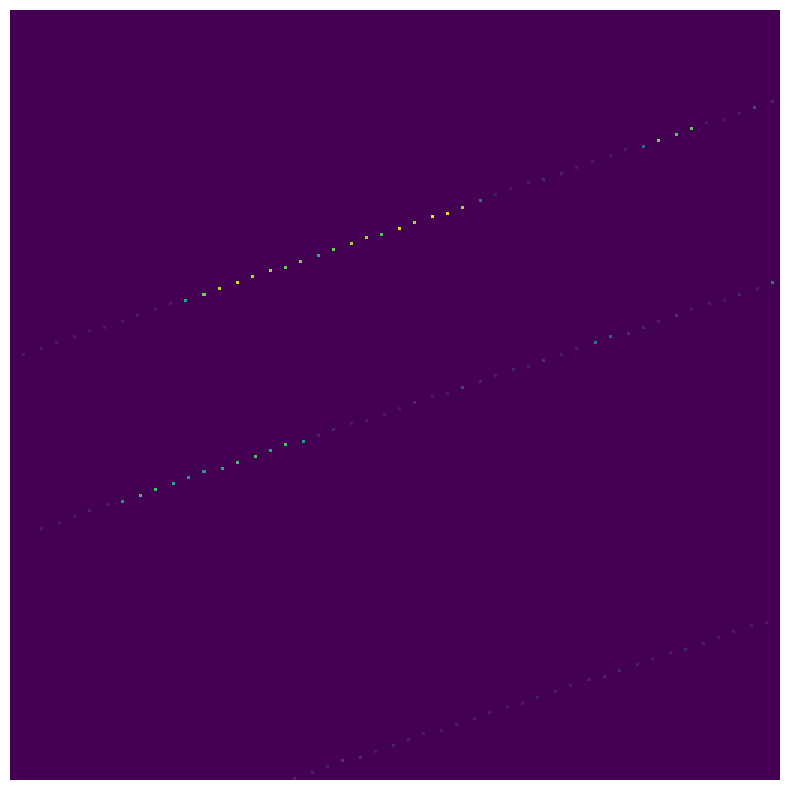

tile shape: (256, 256) s_src: (slice(64, 256, None), slice(64, 192, None)) s_dst: (slice(832, 1024, None), slice(192, 320, None))


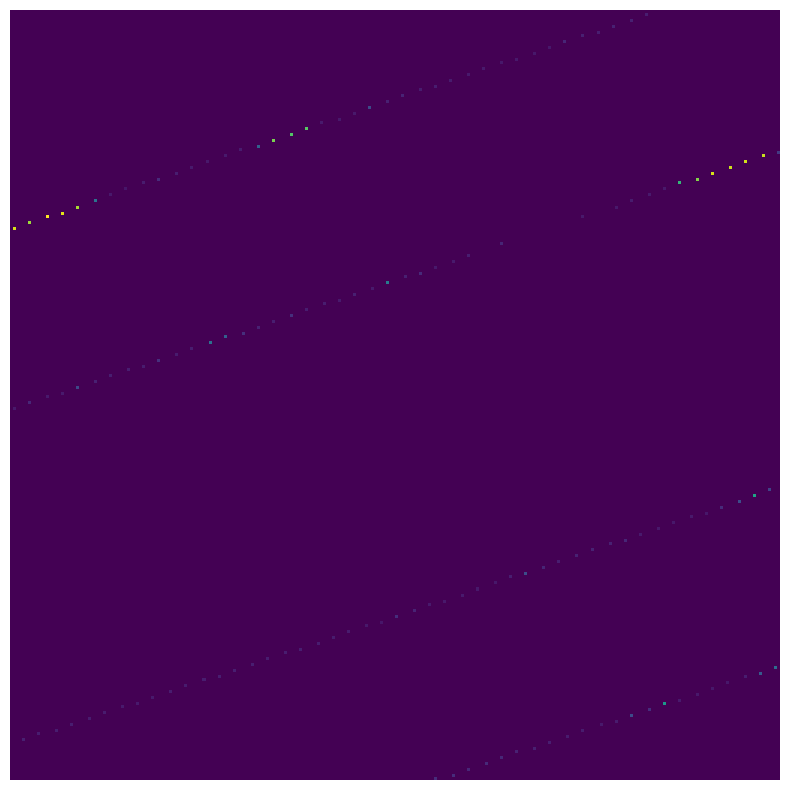

tile shape: (256, 256) s_src: (slice(64, 256, None), slice(64, 192, None)) s_dst: (slice(832, 1024, None), slice(320, 448, None))


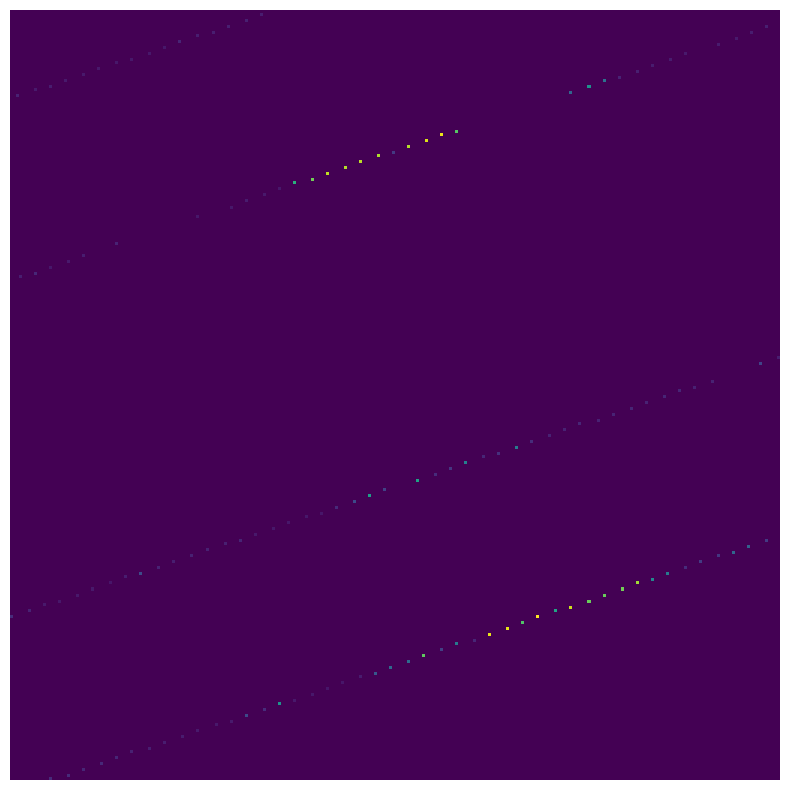

tile shape: (256, 256) s_src: (slice(64, 256, None), slice(64, 192, None)) s_dst: (slice(832, 1024, None), slice(448, 576, None))


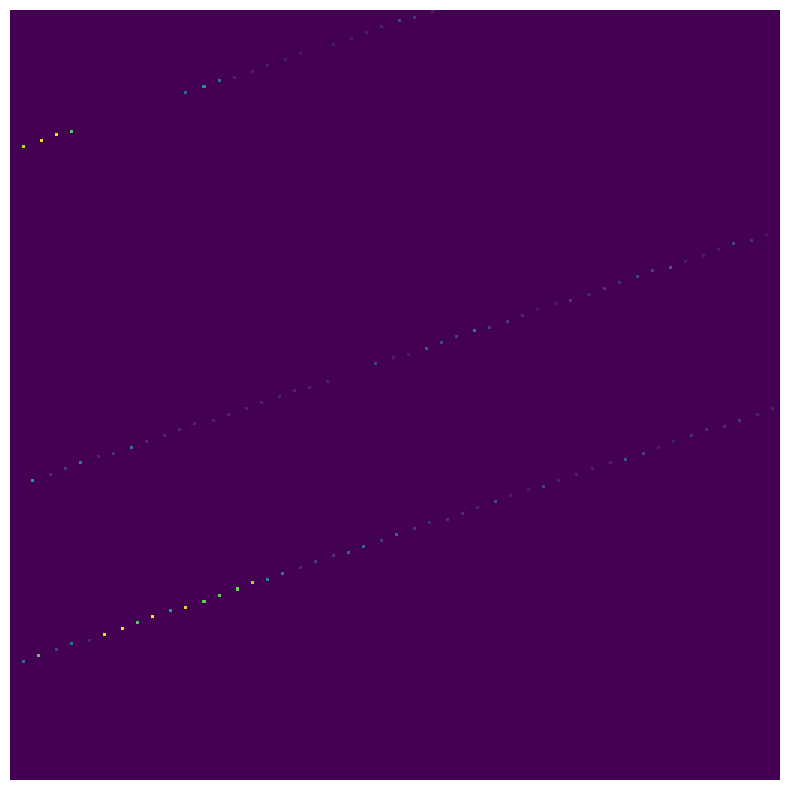

tile shape: (256, 256) s_src: (slice(64, 256, None), slice(64, 192, None)) s_dst: (slice(832, 1024, None), slice(576, 704, None))


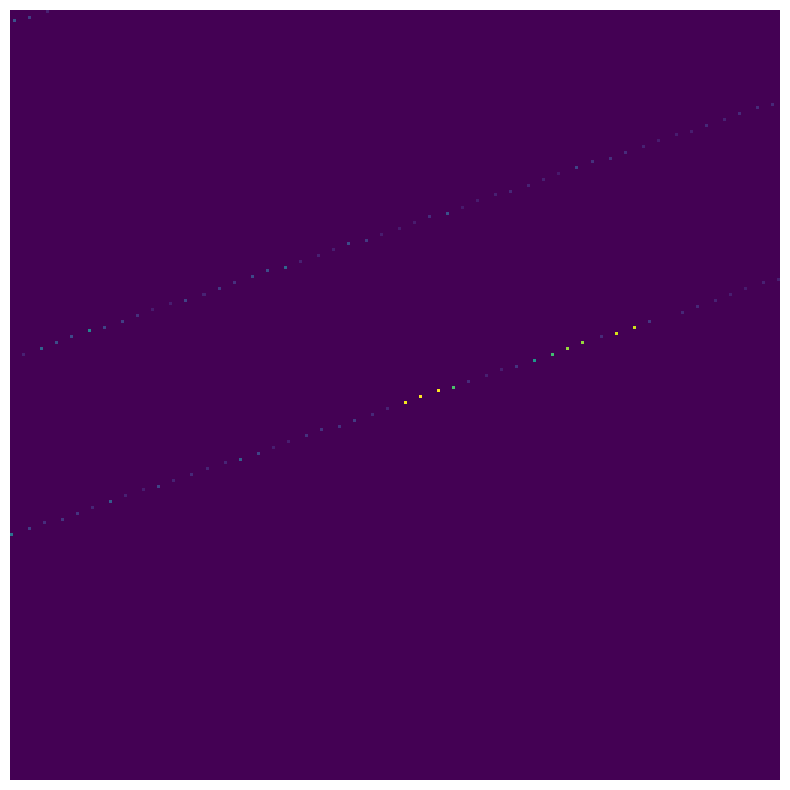

tile shape: (256, 256) s_src: (slice(64, 256, None), slice(64, 192, None)) s_dst: (slice(832, 1024, None), slice(704, 832, None))


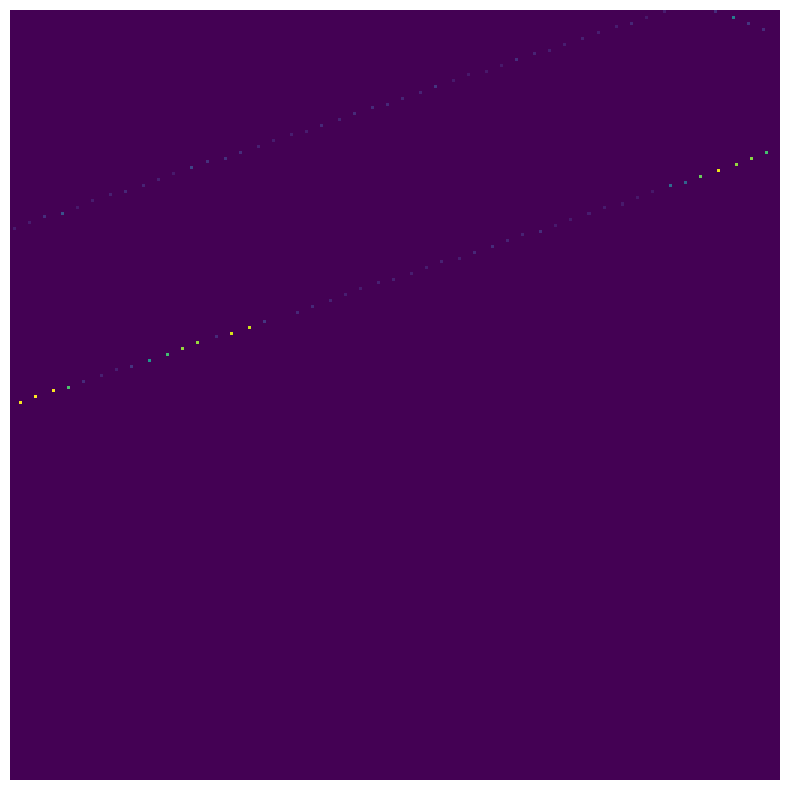

tile shape: (256, 256) s_src: (slice(64, 256, None), slice(64, 256, None)) s_dst: (slice(832, 1024, None), slice(832, 1024, None))


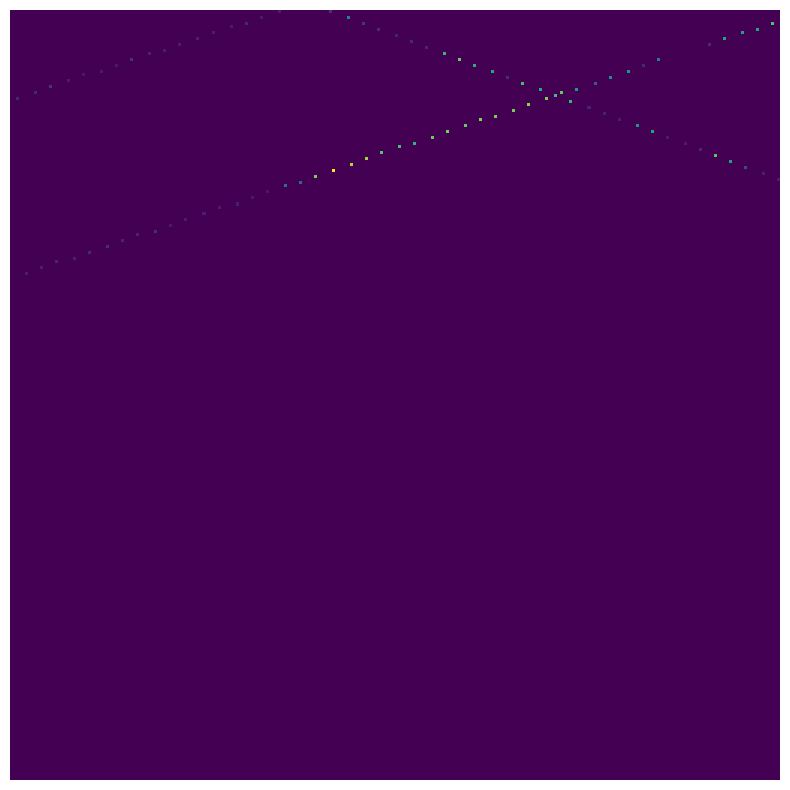

True

In [28]:
!pip install csbdeep

from csbdeep.internals.predict import tile_iterator

img = mask.reshape(1024,1024) # works with 2D-shape (1024, 1024)
result = np.empty_like(img)

for tile,s_src,s_dst in tile_iterator(img, n_tiles=(8,8), block_sizes=(32,32), n_block_overlaps=(2,2)):
    # do something with the tile, e.g. model.predict()
    tile_processed = 2*tile
    # store the result at the correct position
    print("tile shape:", tile_processed.shape, "s_src:", s_src, "s_dst:", s_dst)
    plot_mask_img(tile_processed)
    result[s_dst] = tile_processed[s_src]

np.allclose(result,2*img)

The mask seems to have little dots of values, but not an area of trees, which is usual for a forest. Is that a case of low data quality or is the type of visualization faulty?

Answer: The labels are very sparse, 0s refer to missing values (majority of labels). The location of labels is not perfectly accurate (location up to 2 pixels inaccurate)

### Data Augmentation

In [70]:
# ceil the values at 2000 because clouds have a different reflection value
ceiling = 2000
satellite[satellite > ceiling] = ceiling

In [71]:
scaled_img = satellite[[2,1,0]].transpose(1,2,0)/ceiling

In [81]:
import tensorflow as tf
from tensorflow import keras
#Data augmentation
data_augmentation = tf.keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    #keras.layers.experimental.preprocessing.RandomRotation(0.4),
    #keras.layers.RandomCrop(224, 224)
])

image = scaled_img.reshape((3, 1024, 1024))
image = np.asarray(scaled_img)

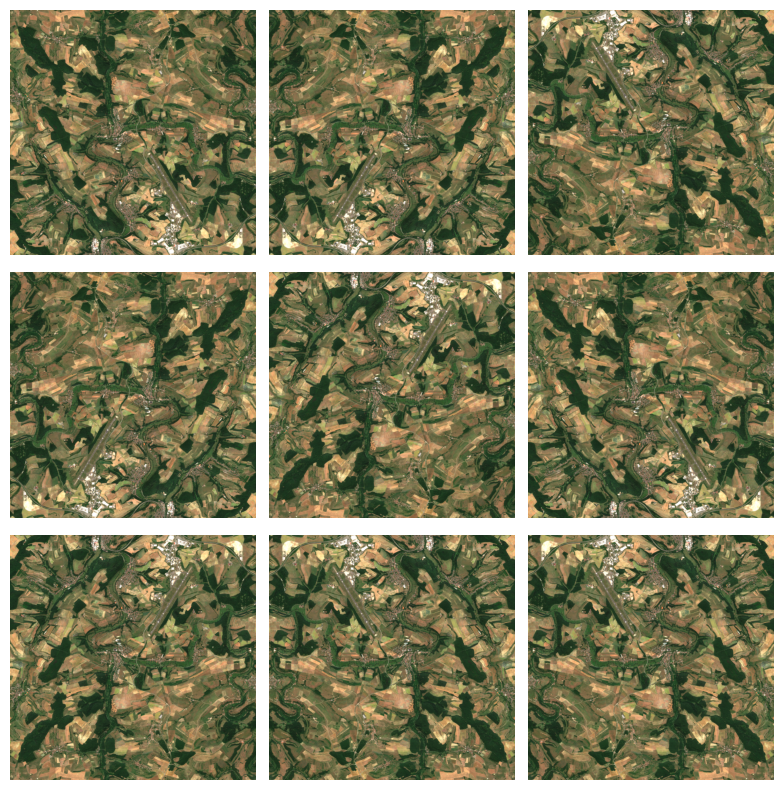

In [84]:
#image = tf.cast(tf.expand_dims(image, 0), tf.float32)
plt.figure(figsize=(10, 10))

for i in range(9):
  augmented_image = data_augmentation(image, training=True)
  ax = plt.subplot(3, 3, i + 1)
  plt.subplots_adjust(hspace=0.07, wspace=0.01)
  plt.imshow(augmented_image)
  plt.axis("off")
  #print(augmented_image.shape)
  #print(i)
  #plot_img(augmented_image)

## Dataset Generation

The npy files are combined into a dataset. After the first loading they do not have to be generated anymore.
One npy file might need to be split into smaller images of 256x256 or 512x512 pixels, which then are put back together in the end.

In [ ]:
# create data sets by combining npy files
path_train_sat = root_path + "train_satellite.npy"
path_train_masks = root_path + "train_masks.npy"

from os import listdir
if not isfile(path_train_sat):
  print("train satellite dataset is generated")
  # image set
  # initialize with the first satellite image
  train_satellite = np.load(path_images + listdir(path_images)[0])
  # concatinate all other images
  for f in listdir(path_images)[1:]:
      current_array = np.load(path_images + f, allow_pickle=True)
      train_satellite = np.concatenate((train_satellite, current_array), axis=0)
  # adjust incorrect shape: (200, 1024, 1024)
  train_satellite = train_satellite.reshape(20, 10, 1024, 1024)
  # save as file
  np.save(path_train_sat, train_satellite, allow_pickle=True, fix_imports=True)
if not isfile(path_train_masks):
  print("train masks dataset is generated")
  # masks
  # initialize with the first mask image
  train_masks = np.load(path_masks + listdir(path_masks)[0])
  # concatinate all other images
  for f in listdir(path_masks)[1:]:
      current_array = np.load(path_masks + f, allow_pickle=True)
      train_masks = np.concatenate((train_masks, current_array), axis=0)
  # save as file
  np.save(root_path + "train_masks.npy", train_masks, allow_pickle=True, fix_imports=True)

In [ ]:
# remove drive connection as it is no longer needed
drive.flush_and_unmount()